# Projeto Final - Engenheiro de Machine Learning

O presente projeto estuda modelos de predição do percentual de cumprimento da meta  ao fim do exercício de 2017 para cada funcionário, além de avaliar os desdobramentos dessas metas por nível hierárquico e entender o impacto e as relações entre o cumprimento delas e as regiões e áreas de atuação da Companhia de Bebidas das Américas - Ambev.

## Importação das bibliotecas e Formato dos gráficos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import gc
from pyxlsb import open_workbook as open_xlsb
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

## Carregamento dos documentos

A base de dados foi fornecida pela Ambev para o data challenge 2018 em parceria com a Udacity. Por fim, cabe esclarecer que cada linha da base de dados está relacionada a cada meta do funcionário. 

In [3]:
df = []
with open_xlsb('ambev.xlsb') as wb:
    with wb.get_sheet(1) as sheet:
        for row in sheet.rows():
            df.append([item.v for item in row])

df = pd.DataFrame(df[1:], columns=df[0])            

In [4]:
new_df = df.copy()

In [5]:
new_df.shape
print ('Número de linhas na base: {}'.format(new_df.shape[0]))
print ('Número de colunas na base: {}'.format(new_df.shape[1]))

Número de linhas na base: 270633
Número de colunas na base: 38


In [6]:
# Drop 5 last columns (None columns)
new_df = new_df.iloc[:,0:33] 
   
# List columns names
columns = new_df.columns.tolist()
new_df.columns = ['Mes', 'Pais', 'Mundo', 'Regiao/Area', 'Unidade', 'Grupo Cargo', 'Cargo', 'Grade', 'Banda',
             'Area', 'Funcionario', 'Gestor', 'Codigo KPI', 'Diretoria', 'Areas Diretoria', 'Funcoes',
             'Tipo Meta', 'Categoria KPI', 'Nome KPI', 'Peso KPI', 'Prazo', 'Regra', 'Meta Projeto',
             '%Ating Metas', '%Pontos Metas', '%Acum Mes', '%Ating Acumulado', '%Pontos Acum', '%Acum Acumulado',
             '%Ating Fim Exer', '%Pontos Fim Exer', '%Acum Fim Exer', 'Status Meta']

## Análise dos dados

In [7]:
def get_meta(df):
    data = []
    for col in df.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif '_id' in col:
            role = 'id'
        else:
            role = 'input'
            
    # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif df[col].dtype == np.object:
            level = 'nominal'
        elif df[col].dtype == np.float64:
            level = 'interval'
        elif df[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col in col_drop:
            keep = False
        elif '_id' in col:
            keep = False

        # Defining the data type 
        dtype = df[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [8]:
col_drop = ['Mes', 'Prazo', 'Regra', 'Meta Projeto','%Ating Metas', '%Pontos Metas', '%Acum Mes', '%Ating Acumulado',
            '%Pontos Acum']
meta_data = get_meta(new_df)
meta_data

role     level   keep    dtype
varname                                          
Mes               input  interval  False  float64
Pais              input   nominal   True   object
Mundo             input   nominal   True   object
Regiao/Area       input  interval   True  float64
Unidade           input  interval   True  float64
Grupo Cargo       input   nominal   True   object
Cargo             input   nominal   True   object
Grade             input  interval   True  float64
Banda             input   nominal   True   object
Area              input   nominal   True   object
Funcionario       input  interval   True  float64
Gestor            input  interval   True  float64
Codigo KPI        input   nominal   True   object
Diretoria         input   nominal   True   object
Areas Diretoria   input   nominal   True   object
Funcoes           input   nominal   True   object
Tipo Meta         input   nominal   True   object
Categoria KPI     input   nominal   True   object
Nome KPI          input  interval   True  float64
Peso KPI          input  interval   True  float64
Prazo             input   nominal  False   object
Regra             input   nominal  False   object
Meta Projeto      input   nominal  False   object
%Ating Metas      input   nominal  False   object
%Pontos Metas     input   nominal  False   object
%Acum Mes         input   nominal  False   object
%Ating Acumulado  input   nominal  False   object
%Pontos Acum      input   nominal  False   object
%Acum Acumulado   input  interval   True  float64
%Ating Fim Exer   input  interval   True  float64
%Pontos Fim Exer  input  interval   True  float64
%Acum Fim Exer    input  interval   True  float64
Status Meta       input   nominal   True   object

In [9]:
print ('Colunas excluidas:', col_drop)

('Colunas excluidas:', ['Mes', 'Prazo', 'Regra', 'Meta Projeto', '%Ating Metas', '%Pontos Metas', '%Acum Mes', '%Ating Acumulado', '%Pontos Acum'])


In [10]:
# drop columns
new_df.drop(col_drop, axis = 1, inplace = True)

In [11]:
meta_counts = meta_data.groupby(['role', 'level']).agg({'dtype': lambda x: x.count()}).reset_index()
meta_counts

role     level  dtype
0  input  interval     12
1  input   nominal     21

In [12]:
columns_qualit = ['Pais', 'Mundo','Grupo Cargo', 'Cargo','Grade','Area','Codigo KPI', 'Diretoria', 'Areas Diretoria', 'Funcoes',
             'Tipo Meta', 'Categoria KPI']        
columns_quant = ['Nome KPI','Peso KPI','%Acum Acumulado','%Ating Fim Exer','%Acum Fim Exer', '%Pontos Fim Exer', 'Status Meta']

## Limpeza 

### Ajuste Categorias

In [13]:
''' Replace misspelling labels '''
def replace_labels(old_category, new_category, category_):
    category = "" + str(category_) + ""
    
    for index in range(len(old_category)):
        old = "" + str(old_category[index]) + ""
        new = "" + str(new_category[0]) + ""
        new_df[category].replace(old, new, inplace=True)

In [14]:
''' Aggregate generic labels '''
def get_generic_labels(value, category_):
    category = "" + str(category_) + ""
    generic_labels = []
    labels_count = 0
    
    x = (new_df[category].value_counts() > value)  
    for i in range(len(x)):
        if x[i] == True:
            labels_count += 1
            
    for index in range(len(new_df[category].value_counts().index)):
        label = new_df[category].value_counts().index[index]
        label_val = new_df[category].value_counts().index[:labels_count]
        if label not in label_val:
            generic_labels.append(label)
    
    return generic_labels 

**Observações**: Depois de excluir as linhas duplicadas ficamos com uma base de dados com 100766 linhas.

In [15]:
new_df = new_df.drop_duplicates(keep='first')

In [16]:
new_df.shape
print ('Número de linhas na base após exclusão de linhas duplicada: {}'.format(new_df.shape[0]))
print ('Número de colunas na base após exclusão de colunas não importantes: {}'.format(new_df.shape[1]))

Número de linhas na base após exclusão de linhas duplicada: 100766
Número de colunas na base após exclusão de colunas não importantes: 24


In [17]:
columns_clean = ['Pais', 'Mundo', 'Grupo Cargo', 'Cargo', 'Area', 'Codigo KPI', 'Diretoria', 'Areas Diretoria', 'Funcoes', 'Tipo Meta', 'Categoria KPI']
for index in range(len(columns_clean)):
    column = columns_clean[index]
    new_df[column] = new_df[column].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')

**Observações**: normalize, encode and replace misspelling words

In [18]:
new_df['Pais'] = new_df['Pais'].replace('PanamA', 'Panama')

**Observação**: Acerto atributo `'Pais'` PanamA

In [19]:
new_df['Categoria KPI'] = new_df['Categoria KPI'].str.lower()
category = []

**Observação**: Acerto labels mais comuns do atributo `'Categoria KPI'` .

In [20]:
old_category = ['rentabilidad / costo', 
                'rentabilidade/ custos (maco, vic, vlc, ebitda, eficiencia e produtividade)'
                'profit/costs (maco, vic, vlc, ebitda, efficiency, productivity)',
                'profitability/ costs (maco, vic, vlc, ebitda, eficiencia y productividad)',
                'rentabilidad/ costos (maco, vic, vlc, ebitda, eficiencia y productividad)',
                'profitability / costs (maco, vic, vlc, ebitda, efficiency and productivity)',
                'a rentabilidad/ costos (maco, vic, vlc, ebitda, eficiencia y productividad)',
                'profit/costs (maco, vic, vlc, ebitda, efficiency, productivity)',
                'rentabilidad / costo', 'profit / costs (maco,vic, vlc, ebitda..)', 
                'rentabilidad / costos (maco, vic, vlc, ebitda, eficiencia y productividad)',
                'profit / costs (maco,vic, vlc, ebitda..)', 'ebitda', 'productivity', 'rentabilidad / costos',
                'rentabilidade/ custos (maco, vic, vlc, ebitda, eficiencia e produtividade)',
                'profitability / costs (maco, vic, vlc, ebitda, efficiency and productivity)',
                'profitability/ cost (maco, vic, vlc, ebitda, eficiency and productivity)']
new_category = ['profitability/cost']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [21]:
old_category = ['long-term projects / initiatives / strategy', 
                'key projects/ lt initiatives/strategy',
                'projects / long-term initiatives / strategy', 
                'a proyectos/ iniciativas a largo plazo/ estrategia',
                'projects/ initiatives/ long-term strategy', 
                'projetos/ iniciativas de longo prazo/ estrategia', 
                'proyectos / iniciativas a largo plazo / estrategia',
                'proyectos/ iniciativas a largo plazo/ estrategia',
                'proyecto', 'project',
                'projetos/ iniciativas de longo prazo/ estratagia']
new_category = ['long-term projects']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [22]:
old_category = ['gentea ea gestao', 
                'gente y gestion',  
                'gentea ya gestion',  
                'people & management', 
                'people ad management', 
                'vpo sustentable - management and people pilar', 
                'relationship', 
                'gente e gestao',
                'people', 'gestion']
new_category = ['people and management']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [23]:
old_category = ['mejora continua', 
                'melhora continua', 
                'mejoria continua', 
                'mejoria contanua', 
                'mejoraa continua', 
                'melhoria contanua', 
                'melhoria continua', 
                'continous improvement']
new_category = ['continuous improvement']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [24]:
old_category = ['market share / volumen', 
                'market share/ volume brewed', 
                'market share / volume',
                'market share/ volume phd', 
                'market share/ volumen', 
                'market share/ volume']
new_category = ['market share']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [25]:
old_category = ['inovacaes/ projeto de inovacaes', 
                'innovaciones / proyecto de innovaciones', 
                'innovaciones',
                'inovacoes/ projeto de inovacoes']
new_category = ['innovations ']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [26]:
old_category = ['imagen de la marca (brandhealth)', 
                'brand health', 
                'imagen de mnarca',  
                'reputacion',
                'imagen de marca',
                'imagem da marca (brandhealth)']
new_category = ['brandhealth']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [27]:
old_category = ['quality', 
                'calidad', 
                'le accuracy', 
                'le accurancy', 
                'qualidade']
new_category = ['accuracy']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [28]:
old_category = ['mundo mejor', 
                'mundo melhor']
new_category = ['better world']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [29]:
old_category = ['cash flow', 
                'reporte de gastos mensual']
new_category = ['cashflow']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [30]:
old_category = ['nivel de servicio']
new_category = ['service level']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [31]:
old_category = ['sinergias caribe']
new_category = ['synergies']

replace_labels(old_category, new_category, 'Categoria KPI')
category.append(new_category[0])

In [32]:
# Generic Labels value_counts > 100
value = 100
generic_labels = get_generic_labels(value, 'Categoria KPI')        
new_category = ['generic']
replace_labels(generic_labels, new_category, 'Categoria KPI')    

**Observação**: Agrupamento das categorias com quantidades menores que 100 na categoria `generic`.

In [33]:
new_df['Categoria KPI'].value_counts()

continuous improvement    40052
profitability/cost        20269
market share              13683
long-term projects         7340
people and management      5489
accuracy                   4556
obz                        3082
cashflow                   1257
better world               1036
dpo                         659
generic                     518
synergies                   498
service level               448
innovations                 435
brandhealth                 317
Name: Categoria KPI, dtype: int64

### Análise dados ausentes 

In [34]:
missingValueColumns = new_df.columns[new_df.isnull().any()].tolist()
df_null = new_df[missingValueColumns] 

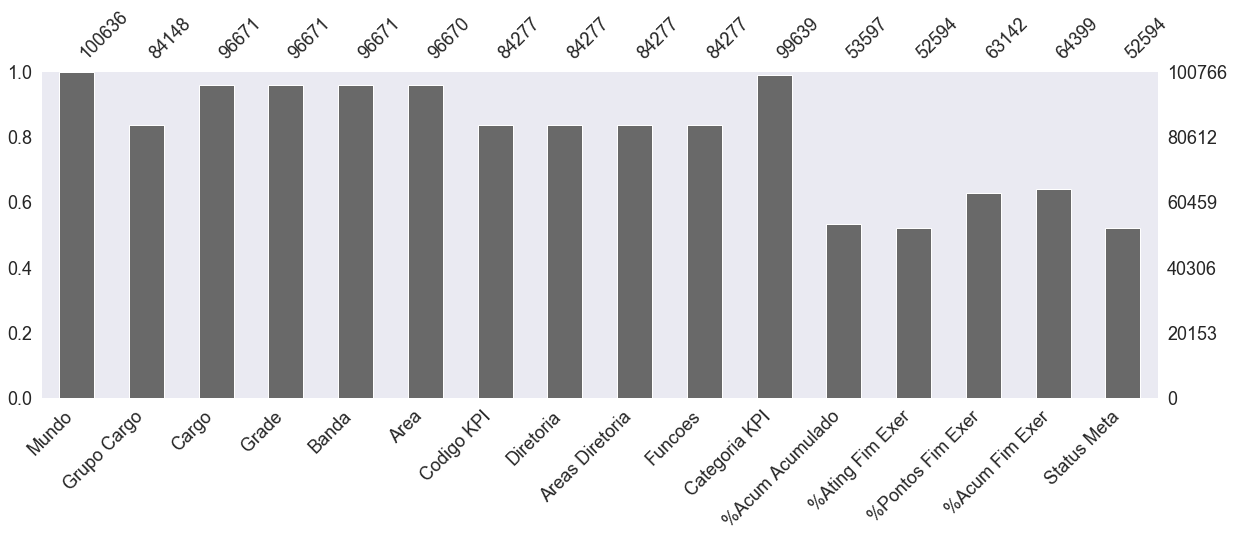

In [35]:
msno.bar(df_null,figsize=(20,6),fontsize=18,labels=True)

Na visualização anterior tem-se as seguintes **observações**:

- As colunas sem 'missing values' não são representadas na visualização: `'Pais'`, `'Regiao/Area'`, `'Unidade'`, `'Funcionario'`, `'Gestor'`, `'Tipo Meta'`, `'Nome KPI'` e `'Peso KPI'`.
- Colunas com poucos 'missing values':  `'Mundo'`,  `'Grupo Cargo'`, `'Cargo'`, `'Grade'`, `'Banda'`,`'Area'`, `'Codigo KPI'`, `'Diretoria'`, `'Areas Diretoria'`, `'Funcoes'` e`'Categoria KPI'`.
- Colunas com a quantidade de 'missing values' próxima da metade do total de dados:`'%Acum Acumulado'`,`'%Ating Fim Exer'`, `'Pontos Fim Exer'`, `'%Acum Fim Exer'`, `'Status Meta'`.


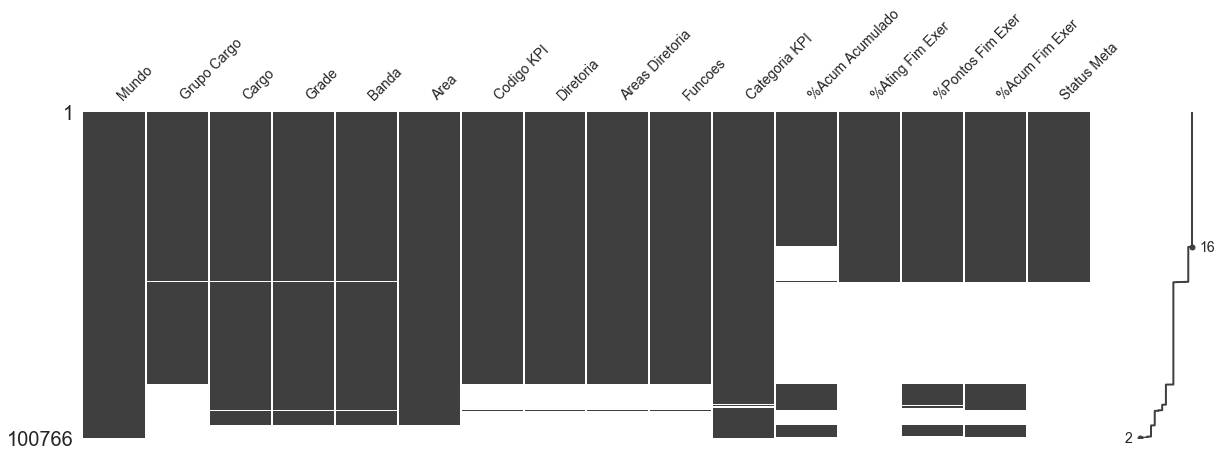

In [36]:
sorted_data = msno.nullity_sort(df_null, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,6),fontsize=14)

Esta é uma representação que sinaliza as linhas com dados faltantes em cada coluna - quaisquer lacunas indicam valores faltantes na matriz de dados. Além disso, à direita temos uma curva que representa a distribuição da integridade dos dados e indica as linhas com o valor máximo e mínimo.

**Observações**: 
- As linhas com valores ausentes nas colunas `'Grupo Cargo'`,`'Código KPI'`, `'Diretoria'`, `'Areas Diretoria'`, `'Funções'` são as linhas que pertencem outros países diferentes do Brasil.
- As variáveis que precisarão ser preenchidas serão a variável `'Pontos Fim Exer'` e a variável `'Status Meta'`. Como pode-se observar a quantidade de dados faltantes nessas duas colunas é grande e não podemos utlizar a média ou a moda desses valores. Para a coluna `'Pontos Fim Exer'` definiremos o valor 0 para os valores faltantes significando que a meta não foi cumprida para essas linhas, de maneira a aplicar um cálculo conservador para a média dos pontos por funcionários ou gerentes. O mesmo faremos para a variável `'Status Meta'`, o valor zero indicará que a meta não foi aprovada.

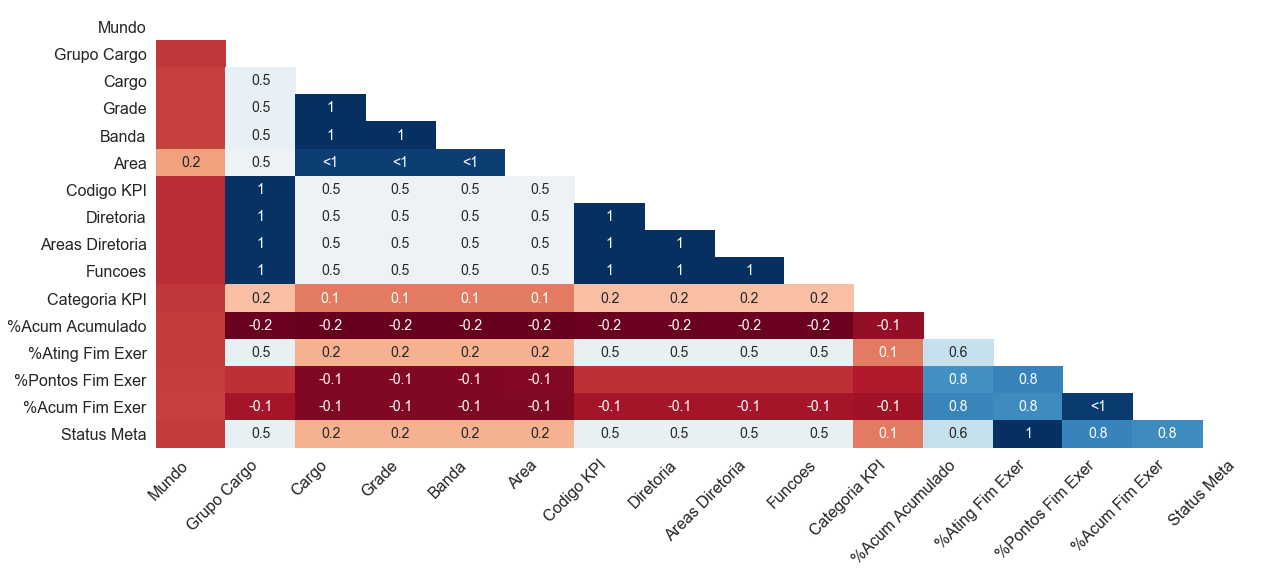

In [37]:
msno.heatmap(df_null,figsize=(20,8))

A coluna acima indica a correlação entre os dados faltantes nas colunas. Sendo assim, valores 1 indicam que as colunas são perfeitamente correlacionadas positivamente e portanto as linhas faltantes das duas colunas são as mesmas. Esse é o caso das colunas:
- `'Código KPI'`,`'Diretoria'`, `'Areas Diretoria'`, `'Funções'` e `'Grupo Cargo'`. **Observações**: como explicado anteriormente a ausência de dados nessas categorias estão fortemente ligadas ao fato de que para os funcionários fora do Brasil esse valor não é preenchido.
- `'Banda'` e `'Grade'`. **Observações**: Isso significa que as categorias `'Banda'` e `'Grade'` provavelmente são categorias com códigos similares para cada funcionário e que talvez seja interessante trabalhar com apenas uma delas na análise. 
Como `'Banda'` é uma variável do tipo object, vamos excluir ela pois irá reduzir a quantidade de colunas no one-hot encoding.
-  `'%Ating Fim Exercicio'` e `'Status Meta'`. **Observações**: essa relação será melhor investigada.

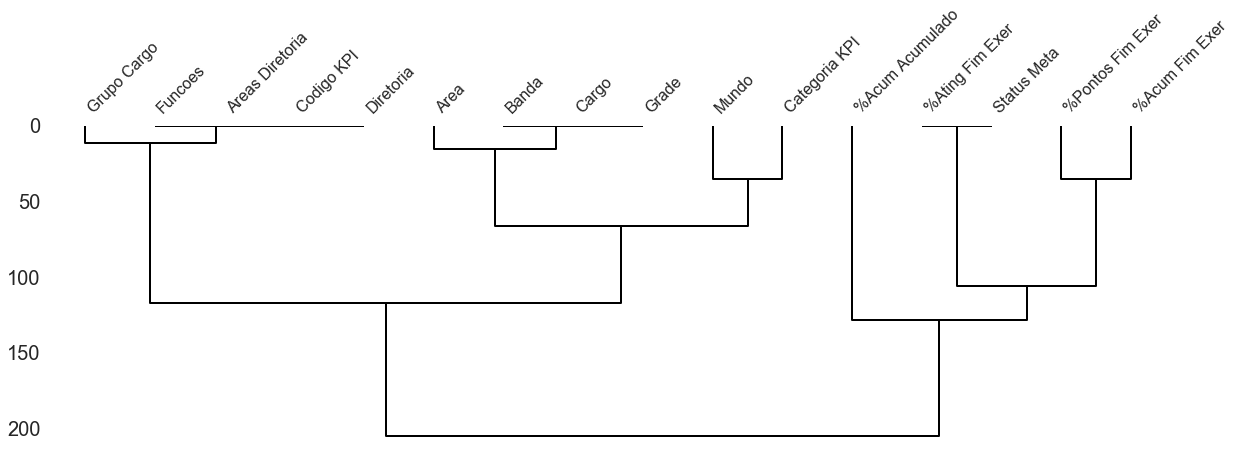

In [38]:
msno.dendrogram(df_null,figsize=(20,6))

### Análise dos atributos contínuos

In [39]:
new_df[columns_quant].describe()

Nome KPI  Peso KPI  %Acum Acumulado  %Ating Fim Exer  %Acum Fim Exer  \
count 100766.00 100766.00         53597.00         52594.00        64399.00   
mean    2826.75     20.27            12.80            90.05           17.42   
std     1426.28      4.46             9.95            26.68            7.88   
min        0.00      0.00             0.00             0.00            0.00   
25%     1605.00     20.00             0.00           100.00           15.00   
50%     3015.00     20.00            16.00           100.00           20.00   
75%     3973.00     20.00            20.00           100.00           20.00   
max     4917.00     80.00           100.00           100.00          100.00   

       %Pontos Fim Exer  
count          63142.00  
mean              85.44  
std               30.86  
min                0.00  
25%              100.00  
50%              100.00  
75%              100.00  
max              100.00

**Observações**: 
- A variável `'Peso KPI'` assume valores de 0.0 a 80.0 onde a média desses valores é 20.0

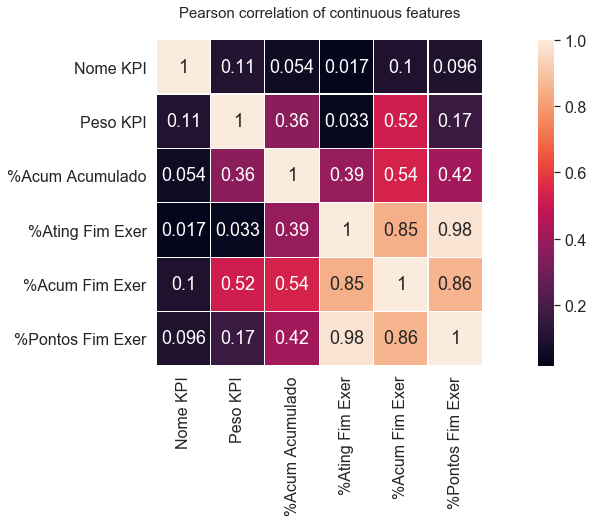

In [40]:
plt.figure(figsize=(20,6))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(new_df[columns_quant].corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

**Observações**:
- A categoria `'Acum Fim Exer'` é fortemente correlacionada com as categorias `'%Ating Fim Exer'` e `'Pontos Fim Exer'` (0.85) e (0.86). Iremos excluir essa categoria uma vez que as outras duas contribuirão para o modelo com informações muito similares a ela.

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


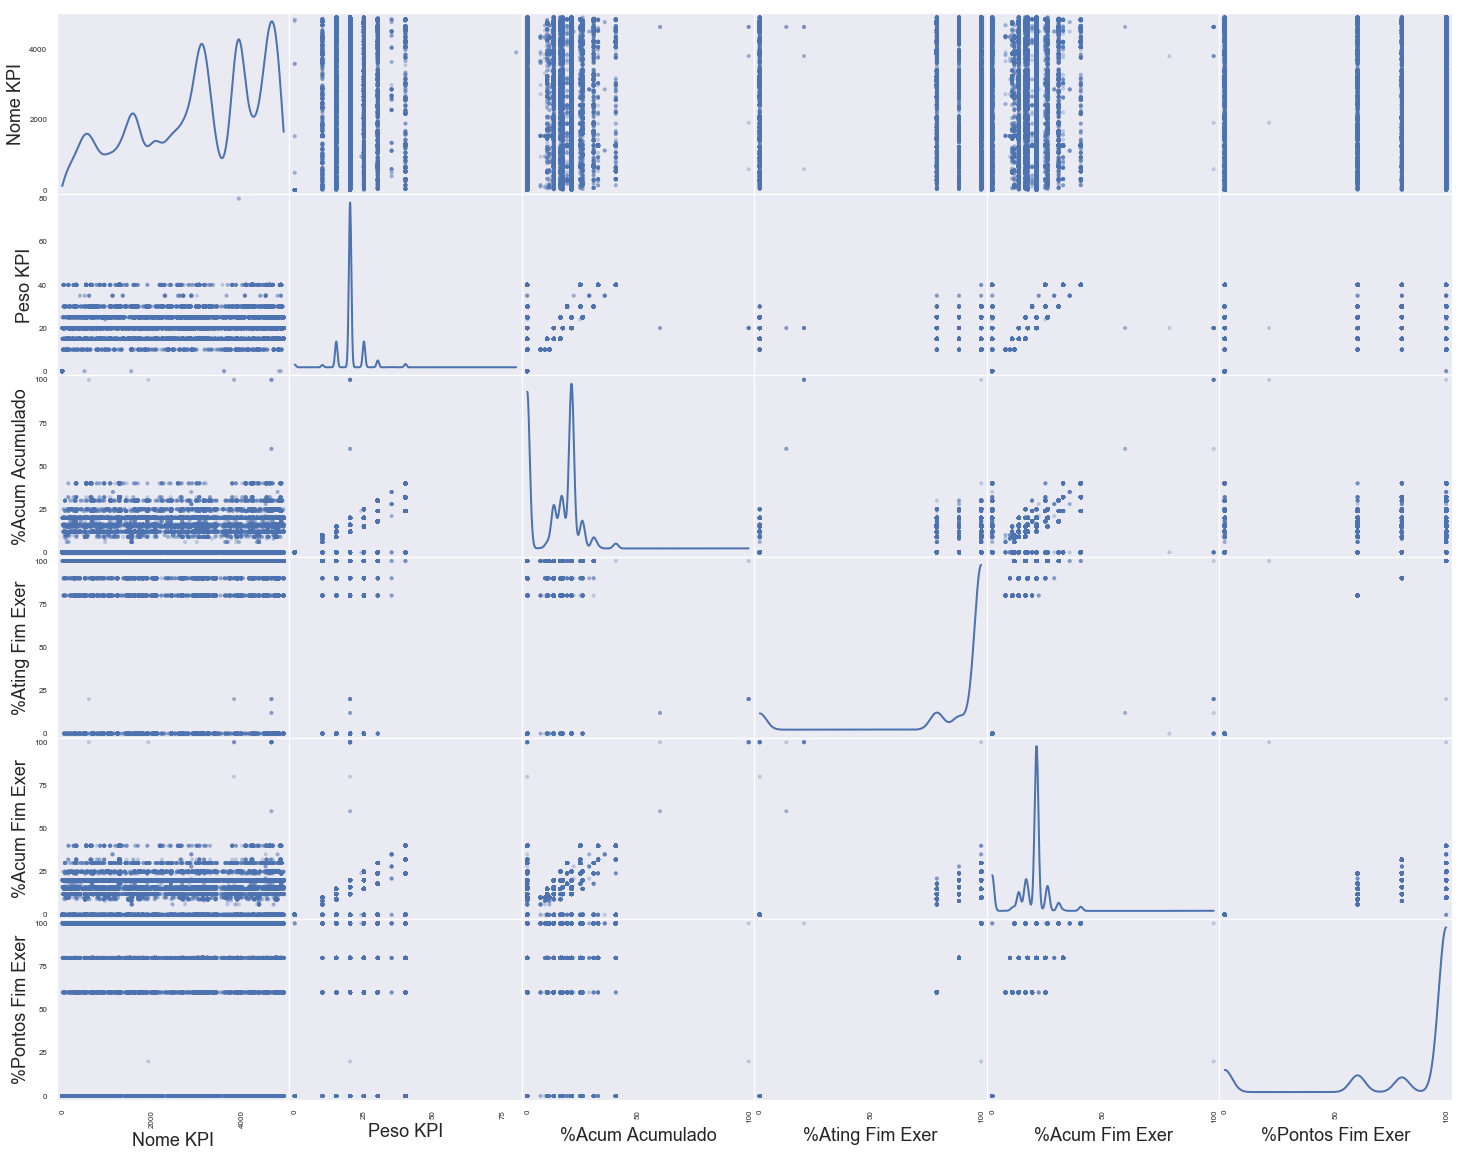

In [41]:
# Produza uma matriz de dispersão para cada um dos pares de atributos dos dados
pd.scatter_matrix(new_df[columns_quant], alpha = 0.3, figsize = (25,20), diagonal = 'kde');

**Observações**: 
- A distribuição da variável `'Peso KPI'` é simétrica em torno do peso 20.0, contudo valores extremos como peso 80.0 induzem a variável a apresentar distribuição assimétrica à direita (moda < mediana < média).
- O mesmo comportamento é observado nas variáveis `'%Acum Acumulado'` e `'%Acum Fim Exer'`. 
- O oposto ocorre com as variáveis `'%Ating Fim Exer'` e `% Pontos Fim Exer` que apresentam distribuições similares assimétricas à esquerda, com média 100.0. 

## Preprocessamento

### Preenchimento dados ausentes 

A etapa de preprocessamento será divididas em subetapas. Primeiro, serão avaliadas as correlações das colunas com a presença de dados faltantes, que serão posteriormente preenchidos com valores 0; com a moda ou a mediana de cada coluna; ou com valores -1 para penalizar a inconsistência da base. A escolha desse preenchimento levará em consideração a análise da distribuição desses valores em cada categoria. 

Vimos, também, que as colunas `'Ating Fim Exer'`,  `'Acum Fim Exer'` e `'% Pontos Fim Exer'` são fortemente correlacionadas  e por isso iríamos excluir a coluna `'Acum Fim Exer'`.

Como vimos anteriormente a média das colunas (`'%Acum Acumulado'`, `'Acum Fim Exer'` e `'Pontos Fim Exer'`) são maiores que zero (que indica um status de não cumprimento da meta), sendo assim como forma de penalização dos funcionários com valores faltantes na base iremos atribuir o valor zero para essas colunas.

Para a variável `'Categoria KPI'` iremos atribuir as linhas ausentes a categoria `outros`.

Como as varíaveis `'Grade'` e `'Banda'` têm a mesma quantidade de linhas ausentes e na matriz de correlação vimos que a relação de ausência entre as linhas de valores ausentes na tabela é 1, iremos utilizar apenas uma das colunas `'Grade'` (pois a coluna `'Banda'` é categorica e isso aumentará o número de colunas depois do processo de one-hot encoding).

Excluiremos a coluna `'Codigo KPI'` pois ela é uma coluna de variáveis categoricas que não podem ser interpretadas e já fazemos uso de informações de KPI nas colunas `'Categoria KPI'`, `'Nome KPI'` e `'Peso KPI'`.

As informações das colunas `'Grupo Cargo'`, `'Cargo'` e `'Funcoes'` são similares no sentido de tentar identificar as obrigações de cada funcionário na empresa. Sendo assim de maneira a utilizar o mínimo de informação redundante possível iremos manter na base apenas a  coluna `'Grupo Cargo'` por ser aquela que detalhada melhor as catacterísticas de cada funcionário.

Por fim, para as variáveis de colunas numéricas `'Grade'` e `'Area'` iremos atribuir o valor -1 aos valores ausentes como forma de penalizar e identificar melhor esses dados na base. Já para as colunas de variáveis categóricas `'Mundo'`, `'Grupo Cargo'`, `'Diretoria'`, `'Areas da Diretoria'` iremos atribuir a esses valores os labels `'Missing'`.

**Observação**: 
- Excluir coluna `'Acum Fim Exer'`.
- Excluir coluna `'Banda'`.
- Excluir coluna `'Codigo KPI'`.
- Excluir coluna `'Cargo'`.
- Excluir coluna `'Funcoes'`.

- Alterar valores faltantes da variável `'Status Meta` para zero.
- Alterar valores faltantes da variável `'%Acum Acumulado'`, `'Acum Fim Exer'` e `'% Pontos Fim Exer'` para zero.

- Atribuir categoria `outros` os valores ausentes da variável `'Categoria KPI`.
- Alterar valores faltantes da variável `'Grade'` e `'Area'` para -1.0.
- Atribuir categoria `Missing` os valores ausentes das variáveis `'Mundo'`, `'Grupo Cargo'`, `'Diretoria'`, `'Areas da Diretoria'`.


In [41]:
new_df.drop(['%Acum Fim Exer'],axis = 1, inplace = True)

In [42]:
new_df.drop(['Banda'],axis = 1, inplace = True)

In [43]:
new_df.drop(['Codigo KPI'],axis = 1, inplace = True)

In [44]:
new_df.drop(['Cargo'],axis = 1, inplace = True)

In [45]:
new_df.drop(['Funcoes'],axis = 1, inplace = True)

In [46]:
new_df['Status Meta'].fillna(0.0, inplace = True)
new_df['%Pontos Fim Exer'].fillna(0.0, inplace = True)
new_df['%Acum Acumulado'].fillna(0.0, inplace = True)
new_df['%Ating Fim Exer'].fillna(0.0, inplace = True)

new_df['Area'].fillna(-1.0, inplace = True)
new_df['Grade'].fillna(-1.0, inplace = True)

In [47]:
new_df['Categoria KPI'].fillna('outros', inplace = True)
new_df['Mundo'].fillna('Missing', inplace = True)
new_df['Grupo Cargo'].fillna('Missing', inplace = True)
new_df['Diretoria'].fillna('Missing', inplace = True)
new_df['Areas Diretoria'].fillna('Missing', inplace = True)

**Observação**: como a variável `'Status Meta'` apresenta valores 0, 12.0, 16.0, 20.0, 100.0 e 'Monitoramento Aprovado', iremos alterar o status de meta como aprovado para 100.0.

In [48]:
new_df['Status Meta'] = new_df['Status Meta'].apply(lambda x: 100 if x == 'Monitoramento Aprovado' else x)

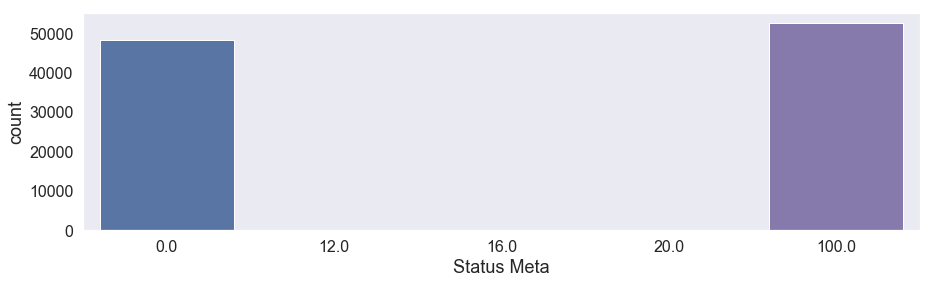

In [49]:
# Verificar colunas desbalanceadas variável Status Meta
plt.figure(figsize=(15,4))
ax = sns.countplot(new_df['Status Meta'],data=new_df)

### Feature Engineering

Criamos novas variáveis para o conjunto de dados que buscam relacionar os valores dos KPI (`'Nome KPI'` e `'Peso KPI'`) com os percentuais de metas atingindos pelos funcionários (`'%Acum Acumulado'`, `'%Ating Fim Exer'` e `'%Pontos Fim Exer'`).

**Observações**: 
- Multiplicar as colunas `'Nome KPI'` e `'Peso KPI'` para criar uma coluna com a média desses valores `'Valor KPI'`.
- Multiplicar as colunas `'%Acum Acumulado'` e `'Valor KPI'` para criar uma coluna com o valor real de KPI atingido desses valores `'Media KPI'`.

In [50]:
new_df['Valor KPI'] = (new_df['Nome KPI'] * new_df['Peso KPI'])/100.0

In [51]:
new_df['KPI Acumulado'] = (new_df['%Acum Acumulado'] * new_df['Valor KPI']) / 100.0 
new_df['KPI Fim Exer'] = (new_df['%Ating Fim Exer'] * new_df['Valor KPI']) / 100.0 
new_df['KPI Pontos'] = (new_df['%Pontos Fim Exer'] * new_df['Valor KPI']) / 100.0 

In [52]:
display(new_df.head())

Pais  Mundo  Regiao/Area  Unidade            Grupo Cargo  Grade  \
0  Brasil  Sales        10.00    78.00  GER DE VENDAS REVENDA  12.00   
1  Brasil  Sales        10.00    78.00  GER DE VENDAS REVENDA  12.00   
2  Brasil  Sales        10.00    78.00  GER DE VENDAS REVENDA  12.00   
3  Brasil  Sales        10.00    78.00  GER DE VENDAS REVENDA  12.00   
4  Brasil  Sales        10.00    78.00  GER DE VENDAS REVENDA  12.00   

          Area  Funcionario  Gestor                           Diretoria  \
0  GERENCIA CD      2774.00  237.00  Diretoria de Vendas e Distribuicao   
1  GERENCIA CD      2774.00  237.00  Diretoria de Vendas e Distribuicao   
2  GERENCIA CD      2774.00  237.00  Diretoria de Vendas e Distribuicao   
3  GERENCIA CD      2774.00  237.00  Diretoria de Vendas e Distribuicao   
4  GERENCIA CD      2774.00  237.00            Diretoria de Refrigenanc   

      ...     Nome KPI Peso KPI %Acum Acumulado  %Ating Fim Exer  \
0     ...      4729.00    25.00            0.00           100.00   
1     ...      3138.00    20.00            0.00             0.00   
2     ...      3103.00    20.00           12.00           100.00   
3     ...      4757.00    15.00           12.00           100.00   
4     ...      4762.00    20.00            0.00             0.00   

   %Pontos Fim Exer  Status Meta  Valor KPI  KPI Acumulado  KPI Fim Exer  \
0            100.00       100.00    1182.25           0.00       1182.25   
1              0.00         0.00     627.60           0.00          0.00   
2            100.00       100.00     620.60          74.47        620.60   
3            100.00       100.00     713.55          85.63        713.55   
4              0.00         0.00     952.40           0.00          0.00   

   KPI Pontos  
0     1182.25  
1        0.00  
2      620.60  
3      713.55  
4        0.00  

[5 rows x 23 columns]

### Análise Variáveis Pontuação

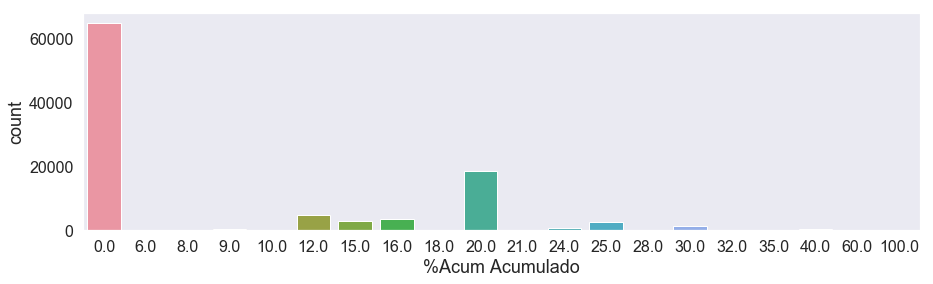

In [53]:
# Verificar colunas desbalanceadas variável target
plt.figure(figsize=(15,4))
ax = sns.countplot(new_df['%Acum Acumulado'],data=new_df)

A variável `'%Acum Acumulado'` indica os percentuais finais cumpridos por meta nos valores 0, 6, 8, 9, 10, 12, 15, 16, 18, 20, 21, 24, 25, 28, 30, 32, 35, 40, 60 e 100%. 

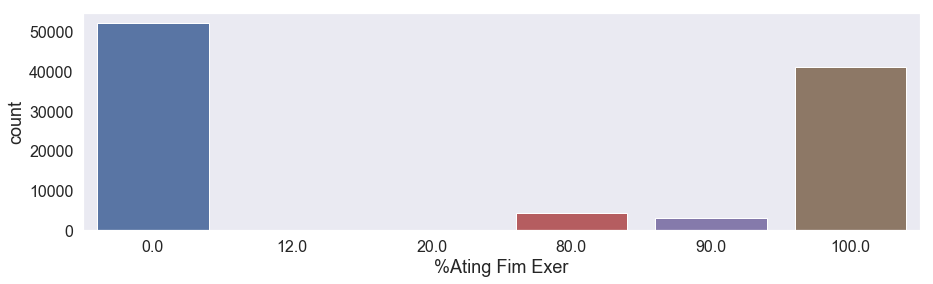

In [54]:
# Verificar colunas desbalanceadas variável target
plt.figure(figsize=(15,4))
ax = sns.countplot(new_df['%Ating Fim Exer'],data=new_df)

A variável `'%Ating Fim Exer'` indica os percentuais finais cumpridos por meta nos valores 0, 12, 20, 80, 90 e 100%.  

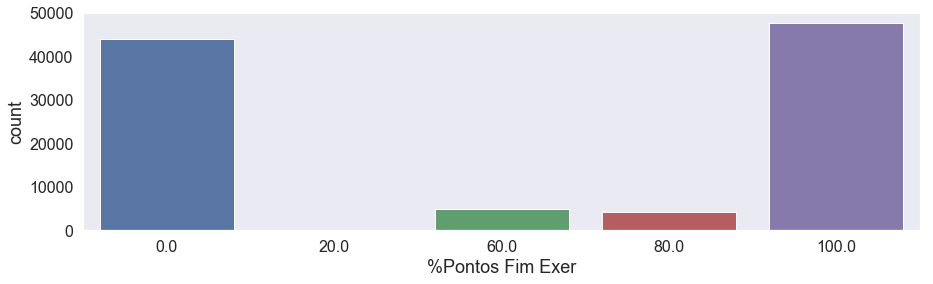

In [55]:
# Verificar colunas desbalanceadas variável target
plt.figure(figsize=(15,4))
ax = sns.countplot(new_df['%Pontos Fim Exer'],data=new_df)

A variável `'%Pontos Fim Exer'` indica os percentuais finais cumpridos por meta nos valores 0, 20, 60, 80 e 100%.  

## Agrupamento

#### Visualização dos atributos agregados:
Cada linha do conjunto de dados representa a meta de um funcionário/gestor em determinada `Pais`, `Mundo`, `Regiao/area`, `Unidade`, `Grupo Cargo`, `Grade`, `Area`, `Diretoria`, `Areas Diretoria`, `Tipo Meta` e `Categoria KPI`. De maneira a visualizar uma linha por funcionário agruparemos o conjunto de dados pelas categorias mais frequentes, pelas média das categorias `Peso KPI`, `%Acum Acumulado`, `%Pontos Fim Exer`, `Valor KPI`, `KPI Acumulado`, `KPI Fim Exer` e `KPI Pontos` e pela quantidade de metas.

In [56]:
# Define the aggregation calculations
aggregations = {
    'Pais': ["max"],
    'Mundo': ["max"],
    'Regiao/Area': ["max"],
    'Unidade': ["max"],
    'Grupo Cargo': ["max"],
    'Grade': ["max"],
    'Area': ["max"],
    'Diretoria': ["max"],
    'Areas Diretoria': ["max"],
    'Categoria KPI': ["max"],
    'Peso KPI': ['mean'],
    '%Acum Acumulado': ['mean'],
    '%Pontos Fim Exer': ['mean'],
    'Valor KPI': ['mean'],
    'KPI Acumulado': ['mean'],
    'KPI Fim Exer': ['mean'],
    'KPI Pontos': ['mean'],
    'Tipo Meta': ["max"],
    'Status Meta': ["mean"],    
    'Funcionario': ["count"]
    }


### Agrupamento por funcionário

In [57]:
def get_columns_aggdata(agg):
    columns = list(agg.columns)
    list_colmuns = []
    for index in range(len(columns)):
        x = columns[index][0]
        if x == 'Funcionario':
            list_colmuns.append('Quantidade Metas')
        else:    
            list_colmuns.append(x)
    return  list_colmuns   

In [58]:
agg = new_df.groupby('Funcionario').agg(aggregations)
agg_df = pd.DataFrame(agg)
columns = agg_df.columns.tolist()
agg_df.columns = get_columns_aggdata(agg)
display(agg_df)

KPI Fim Exer  Valor KPI  Regiao/Area  %Pontos Fim Exer  \
Funcionario                                                           
0.00               608.89     725.97        12.00             85.81   
1.00               444.72     792.12        12.00             60.00   
2.00               392.57     741.66        20.00             42.86   
3.00               161.39     468.78         9.00             27.27   
4.00               406.93     695.48        19.00             50.00   
5.00                 0.00     776.83        21.00              0.00   
6.00               437.00     846.34         9.00             41.25   
7.00               253.40     520.57        19.00             50.00   
8.00               258.19     537.50        21.00             29.41   
9.00                46.37     377.09        16.00             28.57   
10.00              407.45     699.10        19.00             50.00   
11.00                0.00     732.88        21.00              0.00   
12.00                0.00     583.90         2.00              0.00   
13.00              498.74     705.72         8.00             73.64   
14.00              337.07     403.66        12.00             81.43   
15.00              591.05     712.80         9.00             86.36   
16.00              474.42     695.82        20.00             66.67   
17.00              259.20     653.33         9.00             33.33   
18.00               39.76     323.22        14.00             23.53   
19.00               30.94     320.91        12.00             46.67   
20.00              158.89     638.70        19.00             25.00   
21.00                0.00     525.20         3.00              0.00   
22.00              362.18     694.61        20.00             50.00   
23.00                0.00     533.15         3.00              0.00   
24.00              236.45     801.21        11.00             20.00   
25.00              202.06     702.00        21.00             29.41   
26.00              525.78     702.90        20.00             72.73   
27.00              460.77     804.74         7.00             55.00   
28.00              417.68     554.18         8.00             70.00   
29.00              223.73     543.70         3.00             33.33   
...                   ...        ...          ...               ...   
7829.00              0.00     333.56         4.00             41.67   
7830.00              0.00     554.68         4.00             50.00   
7831.00              0.00     476.17         4.00             33.33   
7832.00              0.00     798.68         4.00             60.00   
7833.00              0.00     560.38         4.00             37.14   
7834.00            366.40     562.06        19.00             40.00   
7835.00            290.49     476.28        20.00             42.86   
7836.00             98.44     448.28         1.00             20.00   
7837.00            483.23     678.69         7.00             54.29   
7838.00             33.80     495.48        22.00             20.00   
7839.00              0.00     525.28         4.00             20.00   
7840.00              0.00     685.91         4.00             20.00   
7841.00              0.00     745.48         4.00             67.69   
7842.00              0.00    1176.38         4.00             96.67   
7843.00            312.27     544.73        16.00             27.27   
7844.00            137.40     534.05        21.00             20.00   
7845.00            291.56     560.14        19.00             25.00   
7846.00             72.72     525.73        20.00             20.00   
7847.00            544.49     639.18        20.00             77.78   
7848.00            434.25     707.78        12.00             59.39   
7849.00            323.86     528.76        12.00             61.18   
7850.00             44.00     251.84        16.00             40.00   
7851.00            124.20     452.11        19.00             27.27   
7852.00              0.00     507.16 

## Target

In [59]:
income = agg_df['Status Meta']
features = agg_df.drop('Status Meta', axis = 1)

### Normalizando atributos numéricos

**Observações**: Normalizaremos as variáveis `'Peso KPI'` e `'Nome KPI'`.

In [60]:
scaler = MinMaxScaler() # default=(0, 1)
numerical = [ 'Peso KPI', 'Valor KPI', 'KPI Acumulado', 'KPI Fim Exer', 'KPI Pontos']
features_minmax = pd.DataFrame(data = features)
features_minmax[numerical] = scaler.fit_transform(features_minmax[numerical])

### One-hot enconding

In [61]:
features_proc = pd.get_dummies(features_minmax)
# income_proc = income
income_proc = income.apply(lambda x: 1 if x > 70.0 else 0)

# Print the number of features after one-hot encoding
encoded = list(features_proc.columns)
print "{} total de Features após one-hot encoding.".format(len(encoded))

344 total de Features após one-hot encoding.


# Modelos

## Modelo de benchmark

Será definido um preditor Naive que sempre prediz o cumprimento ou não da meta ao final do exercício, ou seja, ele irá prever que a meta será cumprida com 0 ou 100%. Para isso, será considerado que a meta foi cumprida quando a média do status da meta está acima de 70%. O objetivo desse primeiro modelo é simplesmente exibir como um modelo sem nenhuma inteligência se comportaria. 


In [62]:
TP = np.sum(income_proc) # Contando pois este é o caso "naive". Note que 'income' são os dados 'income_raw' convertidos para valores numéricos durante o passo de pré-processamento de dados.
FP = income_proc.count() - TP # Específico para o caso naive

TN = 0 # Sem predições negativas para o caso naive
FN = 0 # Sem predições negativas para o caso naive

accuracy = float(TP) / (TP + FP)
recall = float(TP) / (TP + FN)
precision = float(TP) / (TP + FP)
fscore = (1  + (0.5**2)) * ( precision * recall / (( 0.5**2 * (precision))+ recall))

# Exibir os resultados 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.3100, F-score: 0.3596]


## Modelo Baseline

O objetivo da próxima etapa é agrupar o conjunto de dados de duas maneiras: por gestor e por funcionário. No agrupamento por gestor, será selecionada uma amostra dos gestores com o maior número de metas cumpridas de maneira a correlacionar com o comportamento das metas dos seus funcionários. Já no agrupamento por funcionário, serão calculadas as médias de pontos obtidos ao final do exercício e a média ponderada dos KPI, pelos seus respectivos pesos. Além desses cálculos, serão adicionados agrupamentos pelos atributos país, mundo,  região/área,  unidade,  grupo cargo,  grade,  banda,  diretoria,  área da diretoria e  tipo meta para obter outros tipos de visualização da base de dados. 

In [60]:
# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features_proc, income_proc, test_size = 0.2, random_state = 0)

print "Base de treino tem {} amostras.".format(X_train.shape[0])
print "Base de teste tem {} amostras.".format(X_test.shape[0])

Base de treino tem 6286 amostras.
Base de teste tem 1572 amostras.


### Extraindo a importância do atributo

In [61]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
features = X_train.columns.values
print("----- Training Done -----")

----- Training Done -----


In [62]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=10):
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [63]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

In [64]:
feature_importance

feature  importance
0   %Pontos Fim Exer        0.19
1       KPI Fim Exer        0.10
2         KPI Pontos        0.10
3    %Acum Acumulado        0.07
4          Valor KPI        0.04
5      KPI Acumulado        0.03
6   Quantidade Metas        0.03
7        Regiao/Area        0.02
8              Grade        0.02
9  Diretoria_Missing        0.02

[Text(0,0.5,u'Importance'),
 Text(0.5,0,u'Variable name'),
 Text(0.5,1,u'Variable importances')]

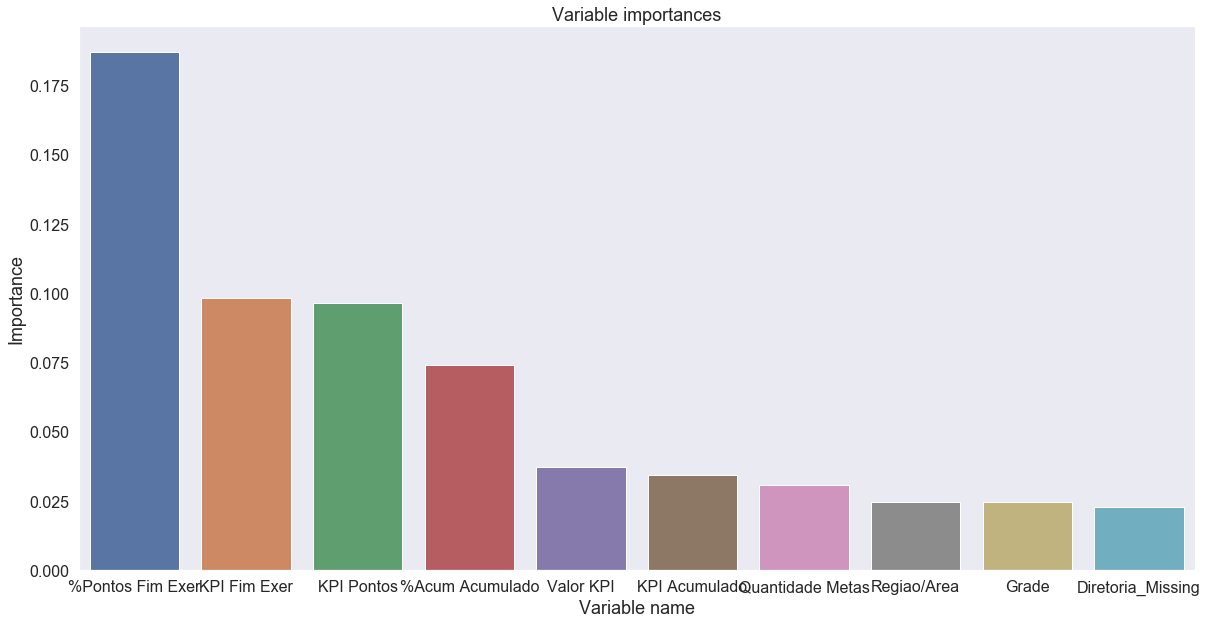

In [65]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10],x="feature",y="importance",ax=ax)
ax.set(xlabel='Variable name', ylabel='Importance',title="Variable importances")

**Observações**: 


### Modelo Classificação

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [67]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)


    ''' StratifiedKFold is a variation of k-fold which returns stratified folds: 
        each set contains approximately the same percentage of samples of each target class as the complete set.

    '''

In [68]:
def cross_val_model(X,y, model, n_splits):   
    X = np.array(X)
    y = np.array(y)
    
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y))
    
    for j, (train_idx, val_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[val_idx]
        y_holdout = y[val_idx]
        
        model.fit(X_train, y_train)
        
        scores = cross_validate(model, X_holdout, y_holdout)
        cross_score_roc = cross_val_score(model, X_holdout, y_holdout, scoring='roc_auc')
        cross_score_f1 = cross_val_score(model, X_holdout, y_holdout, scoring='f1')
        
    return scores, cross_score_roc, cross_score_f1

In [69]:
def get_scores(scores, cross_score_roc, cross_score_f1):       
    metric = []
    mean = []
    std = []
    
    metric.append('ROC')
    metric.append('F1')
    metric.append('ACC Train')
    metric.append('ACC Test')
    metric.append('Fit Time')
    metric.append('Score Time')
    
    train_score = scores['train_score']
    test_score = scores['test_score']
    fit_time = scores['fit_time']
    score_time = scores['score_time']
    
    mean.append(cross_score_roc.mean())
    mean.append(cross_score_f1.mean())
    mean.append(np.mean(train_score))
    mean.append(np.mean(test_score))
    mean.append(np.mean(fit_time))
    mean.append(np.mean(score_time))

    std.append(cross_score_roc.std())
    std.append(cross_score_f1.std())
    std.append(np.std(train_score))
    std.append(np.std(test_score))
    std.append(np.std(fit_time))
    std.append(np.std(score_time))
    
    return metric, mean, std

In [70]:
def display_result(k_fold, clf_model):

    scores, cross_score_roc, cross_score_f1 = cross_val_model(X_train, y_train, clf_model, k_fold)
    metric, mean, std = get_scores(scores, cross_score_roc, cross_score_f1)
    df = pd.DataFrame(data={'Metric': metric,
                                'Mean': mean, 
                                'Std': std})
    columns = df.columns.tolist()
    df = df[['Metric', 'Mean', 'Std']]
    
    return df

### Baseline Models Comparison

**Referências para escolha do algoritmo:**

1) scikit-learn algorithm cheat-scheet: https://udacity-reviews-uploads.s3.us-west-2.amazonaws.com/_attachments/19273/1523538731/ml_map.png

2) Discussão no quora 'How do you choose a machine learning algorithm?': https://www.quora.com/How-do-you-choose-a-machine-learning-algorithm

### Logistic Regression:

**Vantagens:**
- Simples de ser implementado.
- Boa performance em tarefas diversas (modelo baseline)
- Eficiente pois não necessita de altos recurso computacionais
- É interpretável
- Não exige que os recursos de entrada sejam dimensionados
- Fácil regularização
- Alta performance quando removemos os atributos altamente correlacionados

**Desvantagens:**
- Não podemos resolver problemas não lineares com a regressão logística, já que a superfície de decisão é linear
- Necessita de grande quantidade de dados disponíveis para atingir estabilidade e resultados satisfatórios
- Apresentação adequadas dos dados - identificação das variáveis independentes importantes
- Risco de overfitting

**Bom candidato:**

Devido à sua simplicidade e ao fato de que ela pode ser implementada de maneira relativamente fácil e rápida, a Regressão Logística é uma boa referência que você pode usar para medir o desempenho de outros Algoritmos mais complexos.

Referências: https://machinelearning-blog.com/2018/04/23/logistic-regression-101/

### Support Vector Machines (SVM):

**Vantagens:**
- Podem ser adaptados e/ou estendidos para problemas de regressão
- Eficientes classificadores para problemas de elevada dimensionalidade (muitos atributos)
- Consegue lidar bem com grandes conjuntos de exemplos
- Técnica minimiza o risco de overfitting

**Desvantagens:**
- Treinamento longo para grande número de exemplos e dimensionalidade dos dados
- Classificadores do tipo “caixa-preta”, não permitem interpretação da estratégia de decisão claramente

**Bom candidato:**
Após a incorporação das variáveis dummys ficamos com 344 features no nosso conjunto de dados, sendo assim, como o SVM é eficiente para problemas com alta dimensionalidade sua performance não seria comprometida pelo pre-processamento adotado.

### Decision Trees:

**Vantagens:**
- Funciona para dados categóricos ou numérico
- Fácil de compreensão e explicação dos resultados
- Facilmente combinadas com outras ferramentas de tomada de decisão
- Modela problemas com várias saídas
- Confiabilidade pode ser testada e quantificada

**Desvantagens:**
- Ganho de informação tendencioso para os atributos com mais níveis em casos de problemas com dados categóricos com vários níveis.
- Modelo torna-se complexo quando se lida com a incerteza e com muito resultados vinculados, o que pode levar a problemas de sobreajuste.
- Instáveis, no sentido de que pequenas alterações nos dados podem levar a diferentes árvores de decisão.

**Bom candidato:**
Tendo em vista que o nosso conjunto de dados é composto por dados numéricos e categóricos o modelo de árvore de decisão é adequado. Além disso como vimos nas vantagens do modelo a explicação dos resultados é clara, uma vez que o mesmo aplica a técnica de caixa branca. Por fim, caso seja necessário é possível combinados a outros modelos para compor uma ferramenta de tomada de decisão.

### Random Forest

**Vantagens:**
- Algoritmo poderoso de alta performance.
- Aprensenta bom desempenho em problemas diversos, incluíndo os não lineares.
- Custo computacional baixo (as árvores de decisão podem ser treinadas em paralelo).
- Não necessita de normalização das features.

**Desvantagens:**
- Não interpretável.
- Risco de overfitting.
- Dependente da definição do número de árvores.

**Bom candidato:**
Além de ser um algoritmo de alta performance e de custo computacional baixo, é indicado para problemas não lineares (caso dos nossos dados).

Referência: https://www.quora.com/What-are-the-advantages-and-disadvantages-for-a-random-forest-algorithm
http://www.dataversity.net/machine-learning-algorithms-introduction-random-forests/

### Ensemble Methods (AdaBoost):

**Vantagens:**
- Algoritmo simples e fácil de implementar
- Flexível para ser combinado com os outros algoritmos de tomada de decisão

**Desvantagens:**
- Performance do algoritmo depende da escolha dos algoritmos base de aprendizagem (Weak Learners)
- Risco de overfitting 

**Bom candidato:**
Adaboost é um dos algoritmos mais populares de boosting, considerado um classificador de alta qualidade. No caso dos nossos conjuntos de dados, tendo em vista um desquilíbrio das classes esse algoritmo seria um bom candidato.

Referência: https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c



### Ensemble Methods (XGBoost):

XGBoost é um modelo que implenta uma árvore de descisão por vez, de maneira que cada uma delas é incluída para corrigir erros cometidos pela anteriores. Ele é uma implementação de gradient boosted baseado em árvores com o objetivo de reapidez e perfomance na classificação.

**Vantagens:**
- Utilizado para resolver funções deriváveis.
- Velocidade de execução.
- Desempenho.

**Desvantagens:**
- Sensibilidade a overfitting se o conjunto de dados apresenta um volume de ruídos grande.
- Treinamento demorado pois as árvores são construídas sequencialmente.


**Bom candidato:**
Como a performance desse modelo é alta para a maioria dos problemas de classificação se faz necessário comparar os resultados das métricas dos demais modelos a esse.

Referência: https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80

In [71]:
import warnings
warnings.filterwarnings("ignore")

clf_A = RandomForestClassifier(random_state = 42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = SVC(random_state = 42)
clf_D = AdaBoostClassifier(random_state = 42)
clf_E = LogisticRegression(solver='lbfgs')
clf_F = XGBClassifier(random_state = 42)

k_fold = 10

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F]:
    clf_name = clf.__class__.__name__
    print (clf_name)
    df = display_result(k_fold, clf)
    display(df)
    print ('-'*30)

RandomForestClassifier


Metric  Mean  Std
0         ROC  0.96 0.01
1          F1  0.87 0.00
2   ACC Train  1.00 0.00
3    ACC Test  0.92 0.00
4    Fit Time  0.04 0.00
5  Score Time  0.00 0.00

------------------------------
DecisionTreeClassifier


Metric  Mean  Std
0         ROC  0.89 0.03
1          F1  0.86 0.04
2   ACC Train  1.00 0.00
3    ACC Test  0.91 0.02
4    Fit Time  0.01 0.00
5  Score Time  0.00 0.00

------------------------------
SVC


Metric  Mean  Std
0         ROC  0.94 0.02
1          F1  0.85 0.02
2   ACC Train  0.95 0.00
3    ACC Test  0.91 0.01
4    Fit Time  0.05 0.00
5  Score Time  0.02 0.00

------------------------------
AdaBoostClassifier


Metric  Mean  Std
0         ROC  0.96 0.00
1          F1  0.87 0.02
2   ACC Train  1.00 0.00
3    ACC Test  0.92 0.01
4    Fit Time  0.25 0.00
5  Score Time  0.01 0.00

------------------------------
LogisticRegression


Metric  Mean  Std
0         ROC  0.96 0.01
1          F1  0.84 0.01
2   ACC Train  0.93 0.00
3    ACC Test  0.90 0.01
4    Fit Time  0.04 0.00
5  Score Time  0.00 0.00

------------------------------
XGBClassifier


Metric  Mean  Std
0         ROC  0.96 0.01
1          F1  0.87 0.02
2   ACC Train  0.99 0.00
3    ACC Test  0.92 0.01
4    Fit Time  0.39 0.02
5  Score Time  0.00 0.00

------------------------------


#### Análise da comparação dos modelos supervisionados.

Comparei os modelos de aprendizado supervisionado `Floresta Aleatória`, `Árvores de Decisão`, `SVC`, `Classificador AdaBoost`, `Regressão Logística`, `XGBoost`. 

Resumi na tabela abaixo as métricas `ROC`, `F1`, `Acurácia` da base de treino, `Acurácia` da base de teste, `Tempo` de treino e `Tempo` de teste. Podemos ver nela que todos os modelos obtiveram bons resultados, mas que os modelos `Floresta Aleatória`, `Classificador AdaBoost` e `XGBoost` foram os melhores. Cabe lembrar que os parâmetros desses modelos não foram otimizados.

|Models | RandomForest | DecisionTreeClassifier | SVC | AdaBoostClassifier |LogisticRegression | XGBClassifier | 
|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|  :---------------:|  
|Metric	   | Mean - Std  | Mean - Std  | Mean - Std  |Mean - Std  | Mean - Std  | Mean - Std  |
|ROC       | **0.96** - 0.01 | 0.89 - 0.03 | 0.94 - 0.02 | **0.96** - 0.00 | **0.96** - 0.01 | **0.96** - 0.01 |
|F1	       | **0.87** - 0.00 | 0.86 - 0.04 | 0.85 - 0.02 | **0.87** - 0.02 | 0.84 - 0.01 | **0.87** - 0.02 |
|ACC Train | **1.00** - 0.00 | **1.00** - 0.00 | 0.95 - 0.00 | **1.00** - 0.00 | 0.93 - 0.00 | 0.99 - 0.00 |
|ACC Test  | **0.92** - 0.00 | 0.91 - 0.02 | 0.91 - 0.01 |**0.92** - 0.01 | 0.90 - 0.01 | **0.92** - 0.01 |
|Fit Time  | 0.04 - 0.00 | 0.01 - 0.00 | 0.05 - 0.00 | 0.22 - 0.00 | 0.05 - 0.00 | 0.33 - 0.00 |
|Score Time| 0.00 - 0.00 | 0.00 - 0.00 | 0.02 - 0.00 |0.01 - 0.00 | 0.00 - 0.00 | 0.00 - 0.00 |

## Parameter optimization

In [72]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [73]:
def cross_valid_optim(X_train, y_train, k_fold, clf, parameters):
    best_param = []
    acc_unop = []
    f1_unop = []
    roc_unop = []
    acc_best = []
    f1_best = []
    roc_best = []

    X = np.array(X_train)
    y = np.array(y_train)
    folds = list(StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42).split(X, y))    
    for j, (train_idx, val_idx) in enumerate(folds):
        print ("Fit fold %s" % (j+1))
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[val_idx]
        y_holdout = y[val_idx]
    
        grid_obj = GridSearchCV(clf, param_grid = parameters)
        grid_fit = grid_obj.fit(X_train, y_train)
        best_clf = grid_fit.best_estimator_
        predictions = (clf.fit(X_train, y_train)).predict(X_holdout)
        best_predictions = best_clf.predict(X_holdout)
 
        acc_unop.append(accuracy_score(y_holdout, predictions))
        f1_unop.append(f1_score(y_holdout, predictions))
        roc_unop.append(roc_auc_score(y_holdout, predictions))
        acc_best.append(accuracy_score(y_holdout, best_predictions))
        f1_best.append(f1_score(y_holdout, best_predictions))
        roc_best.append(roc_auc_score(y_holdout, best_predictions))
        best_param.append(best_clf)

    return acc_unop, f1_unop, roc_unop, acc_best, f1_best, roc_best, best_param, best_clf

**Observação:** Vimos anteriormente os resultados para os modelos `Floresta Aleatória`, `Classificador AdaBoost` e `XGBoost` foram muito próximos, contudo, como os modelos `Classificador AdaBoost` e `XGBoost` exigem maior esforço computacional no treinamento otimizaremos apenas o modelo `Floresta Aleatória`. Para isso, vamos divir a base de treino em treino e validação para otimizar o conjunto de parâmetros.

Para essa otmização utlizaremos na técnica de grid search a avaliação de cross validação comparando as métricas: acurácia, F1-beta score e ROC AUC

### RandomFlorest

In [75]:
clf = RandomForestClassifier(random_state = 42)

parameters = {'n_estimators' : [25, 50, 100, 200], 
             'max_depth' : [5, 10, 20], 
             'min_samples_leaf' : [2, 5, 10]}

k_fold = 10
acc_unop, f1_unop, roc_unop, acc_best, f1_best, roc_best, best_param_rfc, best_rfc = cross_valid_optim(X_train, y_train, k_fold, clf, parameters)

n_estimators = []
max_depth = []
min_samples_leaf = []
for index in range(len(best_param_rfc)):
    n_estimators.append(best_param_rfc[index].n_estimators)
    max_depth.append(best_param_rfc[index].max_depth)
    min_samples_leaf.append(best_param_rfc[index].min_samples_leaf)
    
n_estimators_best = np.max(n_estimators)
max_depth_best = np.max(max_depth)
min_samples_leaf_best = np.max(min_samples_leaf)

mean_acc_unop = np.mean(acc_unop)
mean_f1_unop = np.mean(f1_unop)
mean_roc_unop = np.mean(roc_unop)
mean_acc_best = np.mean(acc_best)
mean_f1_best = np.mean(f1_best)
mean_roc_best = np.mean(roc_best)

print "\nBest Estimator\n------"                                                                                                                    
print "N.estimators: {}".format(n_estimators_best)
print "Max.Depth: {}".format(max_depth_best)
print "Min.Samples.Leaf: {}".format(min_samples_leaf_best)                                                                                                              
print "\nUnoptimized model\n------"
print "Mean accuracy score on valid data: {:.4f}".format(mean_acc_unop)
print "Mean F-score on valid data: {:.4f}".format(mean_f1_unop)
print "Mean ROC on valid data: {:.4f}".format(mean_roc_unop)
print "\nOptimized Model\n------"
print "Mean accuracy score on the valid data: {:.4f}".format(mean_acc_best)
print "Mean F-score on the valid data: {:.4f}".format(mean_f1_best)
print "Mean ROC on the valid data: {:.4f}".format(mean_roc_best)

Fit fold 1
Fit fold 2
Fit fold 3
Fit fold 4
Fit fold 5
Fit fold 6
Fit fold 7
Fit fold 8
Fit fold 9
Fit fold 10

Best Estimator
------
N.estimators: 200
Max.Depth: 20
Min.Samples.Leaf: 2

Unoptimized model
------
Mean accuracy score on valid data: 0.9386
Mean F-score on valid data: 0.8998
Mean ROC on valid data: 0.9233

Optimized Model
------
Mean accuracy score on the valid data: 0.9426
Mean F-score on the valid data: 0.9076
Mean ROC on the valid data: 0.9316


**Interpretação**: Aplicamos uma validação cruzada com 10 folds. Para cada fold foi anotado os melhores parâmetros e calculado a acurácia, o f-score, o roc auc. Ao final da validação cruzada anotou-se os parâmetros mais frequentes em cada fold (primeira tabela) e calculou-se a média das acurácias, f-score e roc auc (segunda tabela). 


|Parâmetros|Valores|
|:---------:|:---------------:|
|N.estimadores| 200|
|Profundidade Máxima| 20|
|N.mínimo folhas| 2|

É possível perceber pela tabela abaixo que os resultados das métricas foram aprimorados após a otimização dos parâmetros.

|Métrica|Não Otimizado|Otimizado|
|:---------:|:---------:|:---------:|
|Acurácia| 0.9386| 0.9426|
|F-score| 0.8998| 0.9076|
|ROC AUC| 0.9233| 0.9316|



## Resposta Base de Teste

In [76]:
model = best_rfc
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc = roc_auc_score(y_test, pred)

print "\nOptimized Model\n------"
print "Mean accuracy score on the testing data: {:.4f}".format(acc)
print "Mean F-score on the testing data: {:.4f}".format(f1)
print "Mean F-score on the testing data: {:.4f}".format(roc)


Optimized Model
------
Mean accuracy score on the testing data: 0.9555
Mean F-score on the testing data: 0.9241
Mean F-score on the testing data: 0.9419


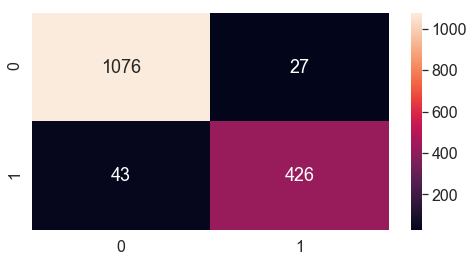

In [77]:
plt.figure(figsize=(8,4))
ax = sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

**Interpretação**: Foi definido anteriormente que se o funcionário soma-se, em média, uma pontuação acima de 70% consideraríamos que ele cumpriu a meta.

Os valores das métricas aplicadas na base de teste obtiveram valores ainda melhores que os aplicados na base de treino.

|Métrica|Base Validação|Base Teste|
|:---------:|:---------:|:---------:|
|Acurácia| 0.9426|0.9555|
|F-score| 0.9076|0.9241| 
|ROC AUC|0.9316|0.9419|


Sendo assim, analisando a matriz de confusão para o modelo escolhido Random Florest percebemos que o modelo classificou corretamente que o funcionário não cumpriu a meta 1076 vezes e que o funcionário cumpriu a meta 426 vezes. O número de vezes que ele obteve uma classificação incorreta somou: 70, das quais 43 vezes o modelo classificou que o funcionário não cumpriria a meta quando na verdade ele foi capaz de cumprir e 27 vezez o modelo classificou que o funcionário cumpriria a meta quando na verdade ele não cumpriu.

# Exploração dos Dados

#### Visualização dos atributos agregados:
Antes de aplicar um modelo de cluster para explorar relações entre as diversas categorias analisaremos a base agrupadas pelos atributos: `Regiao/Area`, `Grade`, `Areas Diretoria`, `Tipo Meta`, `Diretoria` e `Categoria KPI`. Para cada uma das categorias, agruparemos os dados pela maior frequência de cada uma delas, pela média dos pontos na `Status Meta` e pela soma  da `Quantidade Metas`.

In [62]:
def func_plot(gb_df, column, rotation, cat, space, larg, alt):
    %matplotlib inline 
    x = gb_df[column[0]].index
    y1 = gb_df[column[0]].values
    y2 = gb_df[column[1]].values
   
    x_plot = []
    y1_plot = []
    y2_plot = []
   
    for index in range(len(x)):
        x_plot.append(x[index])
        y1_plot.append(y1[index][0])
        y2_plot.append(y2[index][0])
    
    fig = plt.figure(figsize=(larg, alt))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    g = sns.barplot(x = x_plot, y = y1_plot, ax=ax1)
    g.set_xticklabels(x_plot, rotation=rotation)
    g.set(title = str(column[0]) + '/' + 'Media ' + str(column[1]) + ' por ' + str(cat))
    h = sns.barplot(x = x_plot, y = y2_plot, ax=ax2)
    h.set_xticklabels(x_plot, rotation=rotation)
    
    plt.subplots_adjust(hspace=space)


In [63]:
aggregations = {
      'Quantidade Metas': ['sum'],
      'Status Meta': ['mean']
    }

In [64]:
gb_regiao_area = agg_df.groupby('Regiao/Area').agg(aggregations)
gb_area_diretoria = agg_df.groupby('Areas Diretoria').agg(aggregations)
gb_meta = agg_df.groupby('Tipo Meta').agg(aggregations)
gb_diretoria = agg_df.groupby('Diretoria').agg(aggregations)
gb_grade = agg_df.groupby('Grade').agg(aggregations)
gb_cat_kpi = agg_df.groupby('Categoria KPI').agg(aggregations)

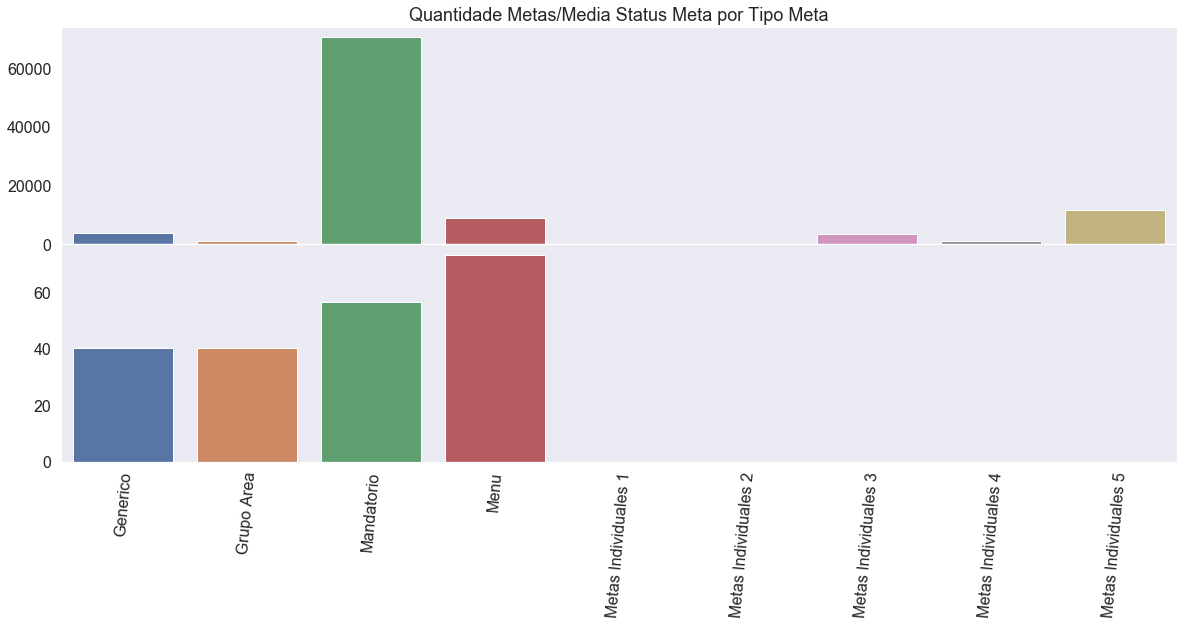

In [65]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_meta, columns, 85, 'Tipo Meta',0.0, 20, 8)

O classificação das metas como  `Mandatório` é a que apresenta o maior volume de metas na base (70.629), seguido da classificação  `Metas Individuais 5` (11.618) e `Menu`	(8.932). Contudo, ao observarmos a médias dos valores das pontuações do atributo `Status Meta` verificamos que a classificação `Menu` tem a melhor pontuação (73,38) seguido da classificação `Mandatório` (56,62). Além disso, podemos ver que as classificações de `Metas Individuais` estão zeradas pois na base não consta os valores dessas pontuações.

In [66]:
display(gb_meta)

Quantidade Metas Status Meta
                                  sum        mean
Tipo Meta                                        
Generico                         3777       40.41
Grupo Area                        939       40.44
Mandatorio                      70629       56.62
Menu                             8932       73.38
Metas Individuales 1                2        0.00
Metas Individuales 2                8        0.00
Metas Individuales 3             3651        0.00
Metas Individuales 4             1210        0.00
Metas Individuales 5            11618        0.04

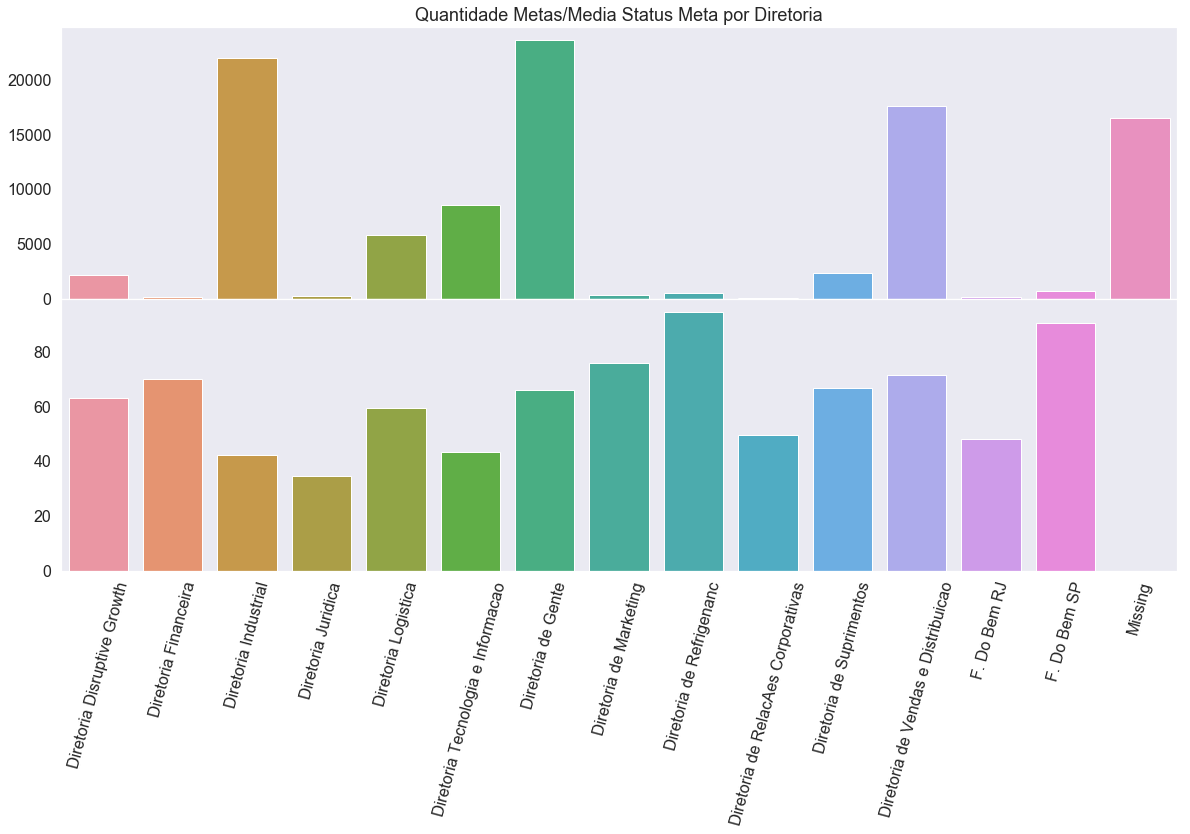

In [67]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_diretoria, columns, 75, 'Diretoria', 0.0, 20, 10)

Podemos observar na Figura acima que a `Diretoria de Gente` é a que possui o maior volume de metas (23.622), seguido das `Diretoria Industrial` (21.930) e `Diretoria de Vendas e Distribuição` (17.595). Podemos observar também que as linhas com a informação de diretorias faltando também apresentam um valor considerado de metas (16.489) e estão associadas as soma da quantidade de `Metas Individuais` (2+8+3651+1210+11.618). Por outro lado, a `Diretoria de Refrigenanc` apresenta o melhor resultado da média da pontuação do atributo `Status Meta` (94,65), seguido da diretoria `F. Do Bem SP` (90,39) a qual por sua vez tem uma quantidade de metas (711) maior que a quantidade de metas da `Diretoria de Refrigenanc` (504). Alcançaram pontuações muito boas também as `Diretoria de Marketing` (75,86), `Diretoria de Vendas e Distribuicao` (71,35), `Diretoria Financeira` (70,08).

In [68]:
display(gb_diretoria)

Quantidade Metas Status Meta
                                                sum        mean
Diretoria                                                      
Diretoria Disruptive Growth                    2200       63.02
Diretoria Financeira                            122       70.08
Diretoria Industrial                          21930       42.14
Diretoria Juridica                              230       34.45
Diretoria Logistica                            5790       59.35
Diretoria Tecnologia e Informacao              8589       43.40
Diretoria de Gente                            23622       65.87
Diretoria de Marketing                          361       75.86
Diretoria de Refrigenanc                        504       94.65
Diretoria de RelacAes Corporativas              112       49.52
Diretoria de Suprimentos                       2309       66.66
Diretoria de Vendas e Distribuicao            17595       71.35
F. Do Bem RJ                                    202       48.26
F. Do Bem SP                                    711       90.39
Missing                                       16489        0.02

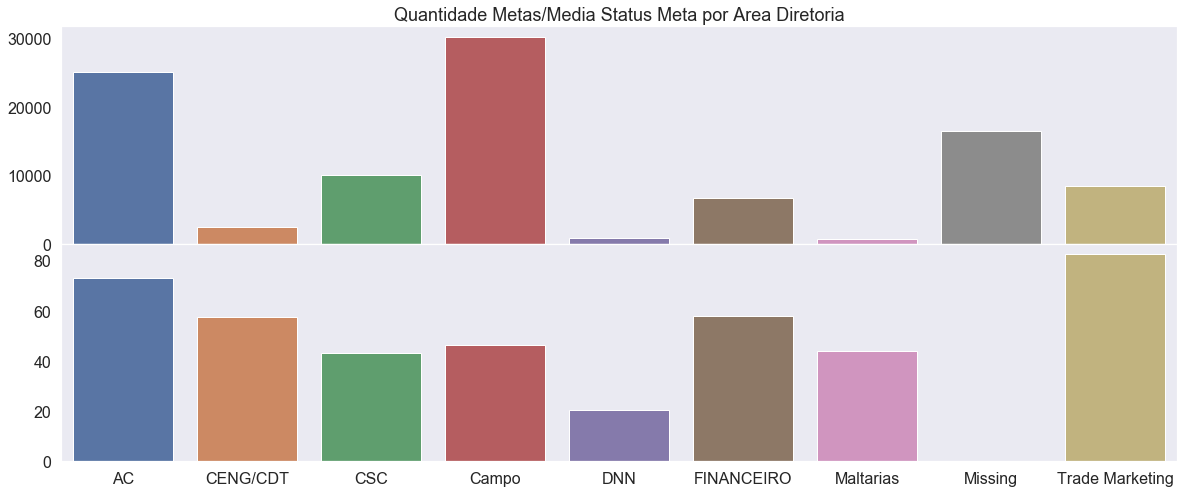

In [69]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_area_diretoria, columns, 0, 'Area Diretoria', 0.0, 20, 8)

Além de avaliar o desempenho das metas por diretoria, na Figura anterior destacamos o desempenho por áreas da diretoria. Nela observamos que as áreas `Campo`, `AC` e `CSC` apressentam o maior número de metas 30.206, 24.994 e 10.019, respectivamente. Quanto a média de pontuação do atributo `Status Meta` percebemos que a área da diretoria `Trade Marketing	` retorna a melhor pontuação (82,52), seguida da área da diretoria `AC` (73,19). 

In [70]:
display(gb_area_diretoria)

Quantidade Metas Status Meta
                             sum        mean
Areas Diretoria                             
AC                         24994       73.19
CENG/CDT                    2517       57.48
CSC                        10019       43.31
Campo                      30206       46.50
DNN                          902       20.59
FINANCEIRO                  6612       58.03
Maltarias                    658       44.03
Missing                    16489        0.02
Trade Marketing             8369       82.52

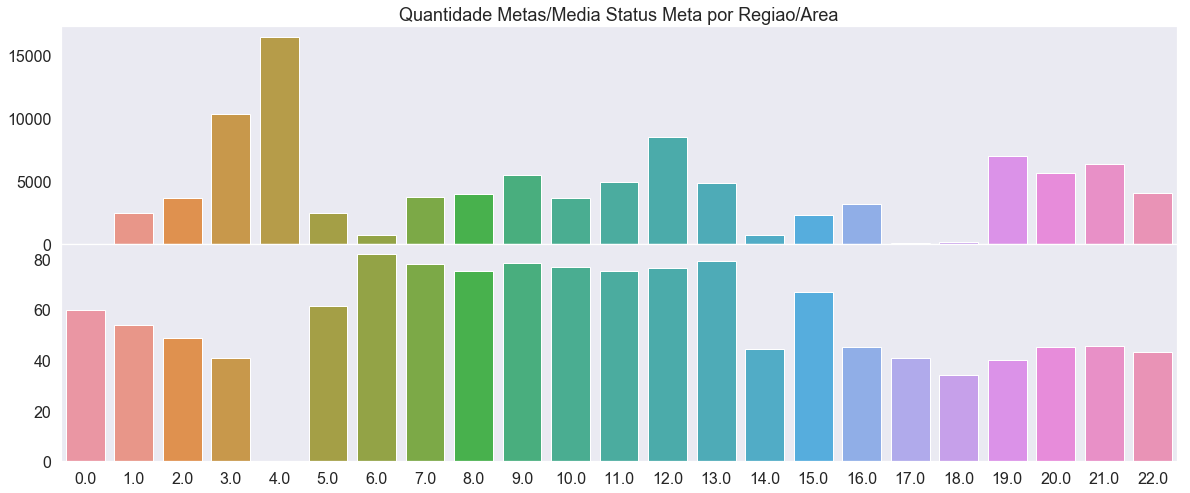

In [71]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_regiao_area, columns, 0, 'Regiao/Area', 0.0, 20, 8)

Por meio da Figura anterior podemos fazer análise das quantidade de metas e a média da pontuação do atributo `Status Meta`, por `Regiao/Area`. A primeira informação que nos chama atenção é a de que a quantidade de metas da regiao/area 4.0 é a que apresenta a maior quantidade de metas (16.489) e estando associada a classificação das `Metas Individuais` não indicam pontuação do `Status Meta`. Em seguida, encontramos as regiões/areas 3.0 com 10.317, 12.0 com 8.510, 19.0 com 7.032 e 21.0 com 6.348 metas. Já as melhores pontuações médias do atributo `Status Meta` forma das regiões/areas 6.0 (81,93), 13.0 (79,23), 9.0 (78,36), 7.0 (77,94), 10.0 (76,80), 12.0 (76,37), 11.0 (75,22) e 8.0 (75,21).

In [72]:
display(gb_regiao_area)

Quantidade Metas Status Meta
                         sum        mean
Regiao/Area                             
0.00                       5       60.00
1.00                    2491       53.95
2.00                    3630       48.88
3.00                   10317       41.06
4.00                   16489        0.02
5.00                    2489       61.51
6.00                     711       81.93
7.00                    3747       77.94
8.00                    3933       75.21
9.00                    5501       78.36
10.00                   3655       76.80
11.00                   4930       75.22
12.00                   8510       76.37
13.00                   4827       79.23
14.00                    722       44.26
15.00                   2295       66.85
16.00                   3209       45.20
17.00                     56       40.97
18.00                    122       34.27
19.00                   7032       40.04
20.00                   5681       45.13
21.00                   6348       45.58
22.00                   4066       43.07

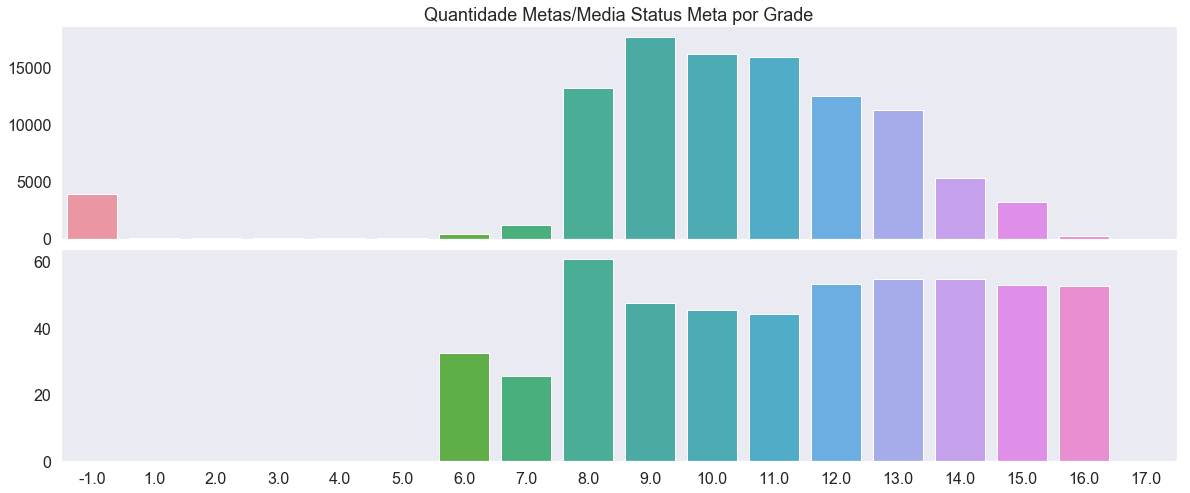

In [73]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_grade, columns, 0, 'Grade', 0.05, 20, 8)


As grades que apresentaram o maior número de metas somadas foram as grades 9.0 (17.644), 10.0 (16.112), 11.0 (15.851), 8.0 (13.113), 12.0 (12.481) e 13.0 (11.262). Por outro lado, em relação a pontuação média alcaçada no atributo `Status Meta` percebemos uma distibuição com valores muito próximos entre 52,68 e 54,91 para as grades 12.0 a 16.0. A grade que mais se destaca na pontuação é a grade 8.0 com média 60,68, ainda assim abaixo do valor objetivo 70.



In [74]:
display(gb_grade)

Quantidade Metas Status Meta
                   sum        mean
Grade                             
-1.00             3903        0.00
1.00                12        0.00
2.00                12        0.00
3.00                16        0.00
4.00                 5        0.00
5.00                41        0.00
6.00               403       32.41
7.00              1165       25.47
8.00             13113       60.68
9.00             17644       47.59
10.00            16112       45.35
11.00            15851       44.10
12.00            12481       53.19
13.00            11262       54.72
14.00             5295       54.81
15.00             3226       52.95
16.00              221       52.68
17.00                4        0.00

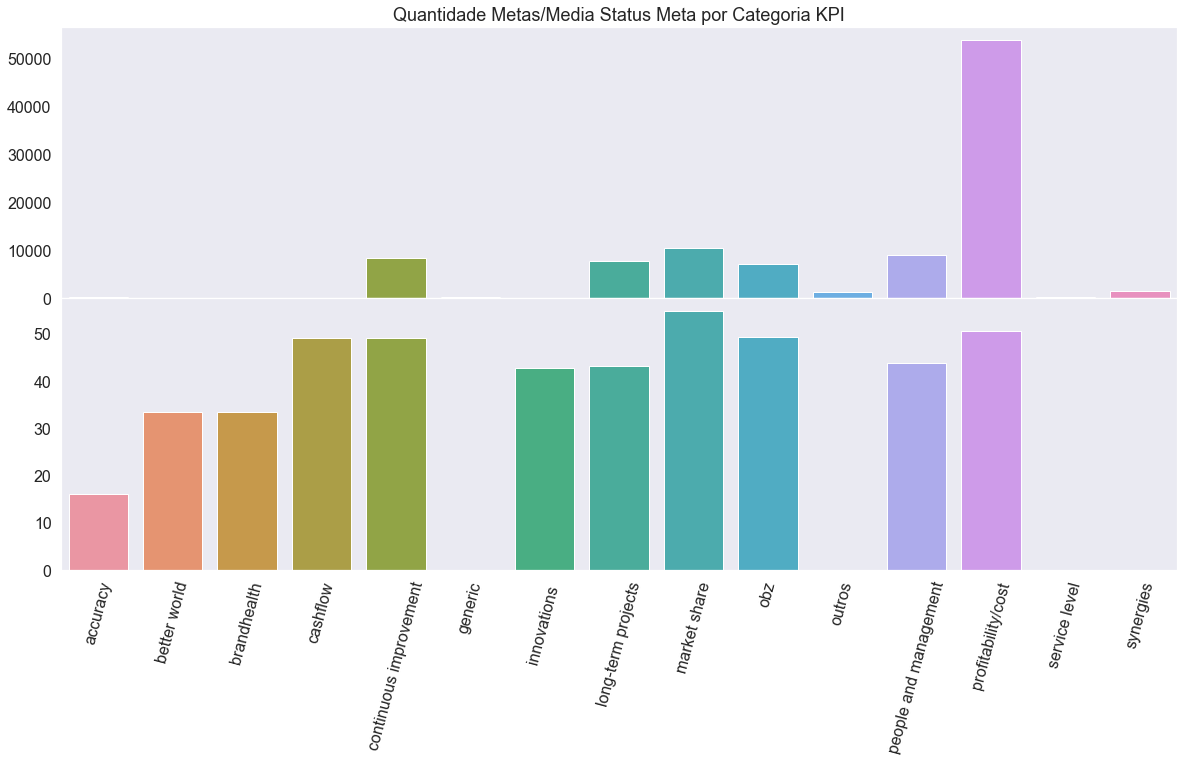

In [75]:
columns = ['Quantidade Metas', 'Status Meta']
func_plot(gb_cat_kpi, columns, 75, 'Categoria KPI', 0.0, 20, 10)

Por fim, podemos observar na análise das categorias em que são classificadas os valores KPI que a categoria `profitability/cost` é a que apresenta o maior quantidade de metas (53.993), valor este muito acima da segunda maior categoria `market share` que soma apenas 10.586 metas. Quanto a pontuação final, calculada pela média dos valores no atributo `Status Meta`, verificamos nenhuma das categorias supera a pontuação de 70.0. Os melhores resultados são das categorias `market share` (54,71), `profitability/cost` (50,57) e `obz` (49,27). 

In [76]:
display(gb_cat_kpi)

Quantidade Metas Status Meta
                                    sum        mean
Categoria KPI                                      
accuracy                            386       16.04
better world                         19       33.33
brandhealth                           6       33.33
cashflow                             60       49.17
continuous improvement             8345       49.11
generic                             287        0.00
innovations                          75       42.68
long-term projects                 7780       43.06
market share                      10586       54.71
obz                                7100       49.27
outros                             1271        0.01
people and management              9035       43.81
profitability/cost                53993       50.57
service level                       296        0.00
synergies                          1527        0.00

## Modelos de Clusterização

### K-Means:

- Vantagens:

1) Simples e fácil de implementar;

2) Fácil interpretação dos resultados de agrupamento;

3) Rápido e eficiente em termos de custo computacional.

- Desvantagens:

1) Assume que os clusters têm densidades semelhantes;

2) Geralmente produzem clusters com tamanho relativamente uniforme, mesmo se os dados de entrada tenham tamanhos de clusters diferentes;

3) Sensível à outliers;

4) Sensível aos pontos iniciais e ao ótimo local;


- **Referência:** https://www.quora.com/What-are-the-advantages-of-K-Means-clustering


Para o modelo de clusterização iremos avaliar as relações entre o cumprimento da meta pela funcionário e a sua relação com os mesmos atributos na análise exploratória anterior: `Regiao/Area`,  `Areas da Diretoria`, `Categoria KPI`,   `Tipo Meta` e `Diretoria`.

Para tanto, agruparemos os valores de `KPI Fim Exer`, `Valor KPI`, `%Pontos Fim Exer`, `Quantidade Metas`, `%Acum Acumulado`, `Peso KPI`, `KPI Acumulado` e `KPI Pontos` para cada uma das categorias e depois aplicaremos o modelo baseline K-means.

In [77]:
# Bibliotecas
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture

In [78]:
def cluster_KMeans(new_data, n_components):
    new_data = scale(new_data)
    cluster_ = cluster.KMeans(n_clusters = n_components).fit(new_data)
    preds = cluster_.predict(new_data)
    centers = cluster_.cluster_centers_
    score = metrics.silhouette_score(new_data, preds)
    return new_data, preds, centers, score

In [79]:
aggregations_cat = {'KPI Fim Exer': ['mean'],
              'Valor KPI': ['sum'],
              '%Pontos Fim Exer': ['mean'],
              'Quantidade Metas': ['sum'],
              '%Acum Acumulado': ['mean'],
              'Peso KPI': ['mean'],
              'KPI Acumulado': ['mean'],
              'KPI Pontos': ['sum'],
              'Status Meta': ['mean']
                }

### Regiao/Area

Vimos anteriormente que a regiao/area 4.0 está muito distante das demais por comportar uma classificação específica de meta que são as `Metas Individuais` e por isso o modelo em um algoritmo de cluster necessariamente irá escolher k=2 clusters, aquele que contem e o que não contem a região 4.0. 

In [80]:
cat = ['Regiao/Area']
regiao_cat = agg_df.groupby(cat).agg(aggregations_cat)
regiao_cat = pd.DataFrame(regiao_cat)
columns_cat = ['KPI Fim Exer', 'Valor KPI', '%Pontos Fim Exer', 'Quantidade Metas', '%Acum Acumulado',
                        'Peso KPI', 'KPI Acumulado', 'KPI Pontos', 'Status Meta']

In [81]:
regiao_cat = regiao_cat.drop(regiao_cat.index[[4]])
regiao_cat = regiao_cat[columns_cat].reset_index()
label = regiao_cat[cat[0]]

In [82]:
for num_clusters in range(2,10): 
    new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters)  
    print("KMeans num_clusters: {} - score: {}".format(num_clusters, score_KMeans))

KMeans num_clusters: 2 - score: 0.36049679959
KMeans num_clusters: 3 - score: 0.372842422158
KMeans num_clusters: 4 - score: 0.394591807595
KMeans num_clusters: 5 - score: 0.394701554064
KMeans num_clusters: 6 - score: 0.40159452146
KMeans num_clusters: 7 - score: 0.369679584342
KMeans num_clusters: 8 - score: 0.398734888348
KMeans num_clusters: 9 - score: 0.355880857215


In [83]:
num_clusters = 6
new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters) 

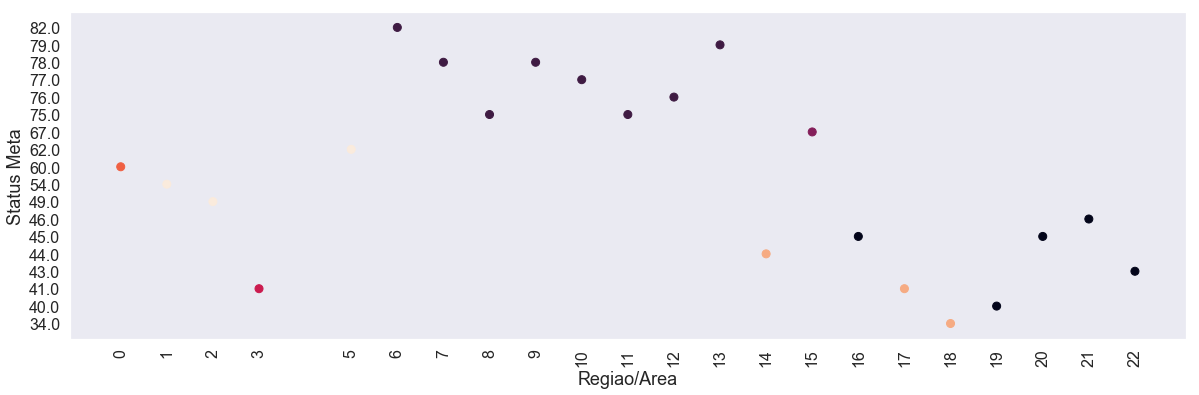

In [84]:
%matplotlib inline
plt.figure(figsize=(20, 6))
regiao_cat['Status Meta'] = regiao_cat['Status Meta'].round()
plt.scatter(regiao_cat[cat[0]],regiao_cat['Status Meta'],  c=preds_KMeans.astype(float))
plt.xticks(rotation=90)
plt.ylabel('Status Meta')
plt.xlabel(cat[0])
plt.xticks(regiao_cat[cat[0]])
plt.show()

In [86]:
regiao_cat['Label'] = label
regiao_cat['Cluster'] = preds_KMeans
display(regiao_cat)

Regiao/Area KPI Fim Exer Valor KPI %Pontos Fim Exer Quantidade Metas  \
                       mean       sum             mean              sum   
0         0.00       244.27    532.06            36.00                5   
1         1.00       248.49 147236.26            49.31             2491   
2         2.00       296.40 187952.09            45.77             3630   
3         3.00       235.18 455371.47            39.09            10317   
4         5.00       211.55  84438.22            53.99             2489   
5         6.00       406.98  22176.50            66.17              711   
6         7.00       417.15 149267.58            65.15             3747   
7         8.00       424.30 153259.41            66.11             3933   
8         9.00       409.64 207674.71            64.36             5501   
9        10.00       414.26 146866.21            63.91             3655   
10       11.00       410.16 199855.02            63.83             4930   
11       12.00       401.71 322465.56            63.35             8510   
12       13.00       430.39 191946.48            67.83             4827   
13       14.00       278.16  38745.53            42.39              722   
14       15.00       329.25 104215.78            64.16             2295   
15       16.00       285.50 173100.02            41.88             3209   
16       17.00       242.94   5021.66            40.69               56   
17       18.00       212.11  11007.35            32.35              122   
18       19.00       247.35 275769.73            37.04             7032   
19       20.00       289.10 304520.00            42.81             5681   
20       21.00       276.71 334774.31            40.97             6348   
21       22.00       275.99 234448.40            40.95             4066   

   %Acum Acumulado Peso KPI KPI Acumulado KPI Pontos Status Meta Label Cluster  
              mean     mean          mean        sum        mean                
0             9.60    20.00         48.56     183.20       60.00  0.00       4  
1             6.15    20.19         30.15   71032.42       54.00  1.00       6  
2             5.29    20.13         33.88   95449.63       49.00  2.00       6  
3             3.80    20.01         22.43  198944.76       41.00  3.00       3  
4             5.19    19.52         21.97   35523.37       62.00  5.00       6  
5             6.05    20.06         37.96   15281.48       82.00  6.00       1  
6             7.42    20.00         46.94   99014.61       78.00  7.00       1  
7             8.77    20.01         55.95  105099.01       75.00  8.00       1  
8             7.71    19.99         47.72  137737.42       78.00  9.00       1  
9             7.61    19.98         47.81   96962.52       77.00 10.00       1  
10            7.91    20.04         50.50  133731.80       75.00 11.00       1  
11            7.32    19.97         45.98  212534.46       76.00 12.00       1  
12            7.68    19.98         48.12  134485.08       79.00 13.00       1  
13            4.94    20.08         32.51   19314.34       44.00 14.00       5  
14            7.24    18.24         39.09   63216.71       67.00 15.00       2  
15            4.47    20.03         30.86   85530.23       45.00 16.00       0  
16            6.62    20.00         42.19    2176.53       41.00 17.00       5  
17            3.50    20.03         22.15    4216.74       34.00 18.00       5  
18            4.67    20.02         32.31  119408.15       40.00 19.00       0  
19            4.70    20.04         31.10  149162.19       45.00 20.00       0  
20            4.82    20.03         32.08  155877.18       46.00 21.00       0  
21            4.69    20.03         32.26  111828.36       43.00 22.00       0

Para o modelo Kmeans verificamos que o [coeficiente de silhueta](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) retornou melhor resultado para 7 clusters. Além disso, podemos perceber pela Figura anterior que `regiao/area` com valores próximos tiveram uma tendência em serem agrupados nos mesmos clusters. Sendo asssim, as `regiao/area` 1.0, 2.0, e 5.0 foram agrupadas em um único cluster, assim como as `regiao/area` 6.0 a 13.0, as`regiao/area` 14.0, 17.0, 18.0 e as `regiao/area` 16.0, 19.0, 20.0, 21.0 e 22.0. Contudo, a `regiao/area` 15.0 foi isolada em um cluster indicando que essa região tem características particulares. O mesmo ocorreu para a `regiao/area` 0.0, que representa as linhas faltantes na tabela.

### Diretoria

In [87]:
cat = ['Diretoria']
regiao_cat = agg_df.groupby(cat).agg(aggregations_cat)
regiao_cat = pd.DataFrame(regiao_cat)
columns_cat = ['KPI Fim Exer', 'Valor KPI', '%Pontos Fim Exer', 'Quantidade Metas', '%Acum Acumulado',
                        'Peso KPI', 'KPI Acumulado', 'KPI Pontos', 'Status Meta']

In [88]:
regiao_cat = regiao_cat[columns_cat].reset_index()
regiao_cat = regiao_cat.drop(regiao_cat.index[[-1]])
label = regiao_cat[cat[0]]

In [89]:
regiao_cat = regiao_cat.drop(cat[0], axis = 1)

/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [90]:
for num_clusters in range(2,10): 
    new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters)  
    print("KMeans num_clusters: {} - score: {}".format(num_clusters, score_KMeans))

KMeans num_clusters: 2 - score: 0.252463749548
KMeans num_clusters: 3 - score: 0.370250788318
KMeans num_clusters: 4 - score: 0.34484342004
KMeans num_clusters: 5 - score: 0.295795875883
KMeans num_clusters: 6 - score: 0.219927316499
KMeans num_clusters: 7 - score: 0.188135099647
KMeans num_clusters: 8 - score: 0.181760934465
KMeans num_clusters: 9 - score: 0.178765254224


In [91]:
num_clusters = 3
new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters) 

In [92]:
regiao_cat['Label'] = label
regiao_cat['Cluster'] = preds_KMeans
display(regiao_cat)

KPI Fim Exer  Valor KPI %Pontos Fim Exer Quantidade Metas %Acum Acumulado  \
           mean        sum             mean              sum            mean   
0        213.31   75500.82            55.55             2200            5.31   
1        264.30    5415.36            63.18              122            5.32   
2        277.60 1142730.00            39.42            21930            4.51   
3        141.65   13178.28            31.81              230            2.55   
4        306.12  254329.61            53.92             5790            6.57   
5        249.42  364896.84            41.56             8589            4.02   
6        352.34  950078.88            57.34            23622            6.84   
7        273.65   15608.39            67.14              361            9.02   
8        523.98   27980.20            81.30              504           10.26   
9        183.99    4560.89            49.52              112            5.02   
10       329.70  104484.73            63.93             2309            7.24   
11       388.99  763086.41            59.35            17595            6.97   
12       213.82    7728.98            41.84              202            3.55   
13       428.73   21064.97            69.77              711            6.85   

   Peso KPI KPI Acumulado KPI Pontos Status Meta  \
       mean          mean        sum        mean   
0     19.46         22.08   32292.59       63.02   
1     20.86         23.21    3132.57       70.08   
2     20.06         31.93  546873.37       42.14   
3     20.18         11.05    3957.71       34.45   
4     20.00         37.69  130722.89       59.35   
5     20.01         23.69  168826.60       43.40   
6     19.98         40.71  573383.56       65.87   
7     20.20         33.98    9644.09       75.86   
8     20.00         61.57   22700.70       94.65   
9     19.73         19.30    2023.89       49.52   
10    18.28         39.15   63314.00       66.66   
11    20.03         46.02  471611.74       71.35   
12    20.17         18.98    3098.26       48.26   
13    20.00         40.71   15128.23       90.39   

                                 Label Cluster  
                                                
0          Diretoria Disruptive Growth       1  
1                 Diretoria Financeira       1  
2                 Diretoria Industrial       2  
3                   Diretoria Juridica       1  
4                  Diretoria Logistica       1  
5    Diretoria Tecnologia e Informacao       1  
6                   Diretoria de Gente       2  
7               Diretoria de Marketing       0  
8             Diretoria de Refrigenanc       0  
9   Diretoria de RelacAes Corporativas       1  
10            Diretoria de Suprimentos       0  
11  Diretoria de Vendas e Distribuicao       2  
12                        F. Do Bem RJ       1  
13                        F. Do Bem SP       0

Para o modelo Kmeans verificamos que o [coeficiente de silhueta] retornou melhor resultado para 3 clusters, nos quais as diretorias `Diretoria Industrial`, `Diretoria de Gente` e `Diretoria de Vendas e Distribuicao` foram alocadas no mesmo cluster. Podemos verificar que essas diretorias têm o maior número de metas e valores de KPI. Em um segundo cluster foram agrupadas as diretorias `Diretoria de Marketing`, `Diretoria de Refrigenanc`, `Diretoria de Suprimentos` e `F. Do Bem SP`, que apresentaram valor altos das médias das pontuações do atributo `Status Meta`.

### Áreas Diretoria

In [93]:
cat = ['Areas Diretoria']
regiao_cat = agg_df.groupby(cat).agg(aggregations_cat)
regiao_cat = pd.DataFrame(regiao_cat)
columns_cat = ['KPI Fim Exer', 'Valor KPI', '%Pontos Fim Exer', 'Quantidade Metas', '%Acum Acumulado',
                        'Peso KPI', 'KPI Acumulado', 'KPI Pontos', 'Status Meta']

In [94]:
regiao_cat = regiao_cat[columns_cat].reset_index()
regiao_cat = regiao_cat.drop(regiao_cat.index[[7]])
label = regiao_cat[cat[0]]

In [95]:
regiao_cat = regiao_cat.drop(cat[0], axis = 1)

In [96]:
for num_clusters in range(2,8): 
    new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters)  
    print("KMeans num_clusters: {} - score: {}".format(num_clusters, score_KMeans))

KMeans num_clusters: 2 - score: 0.192268568503
KMeans num_clusters: 3 - score: 0.21211493116
KMeans num_clusters: 4 - score: 0.191225933656
KMeans num_clusters: 5 - score: 0.162639953619
KMeans num_clusters: 6 - score: 0.111896133597
KMeans num_clusters: 7 - score: 0.0507386867991


In [97]:
num_clusters = 3
new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters) 

In [98]:
regiao_cat['Label'] = label
regiao_cat['Cluster'] = preds_KMeans
display(regiao_cat)

KPI Fim Exer  Valor KPI %Pontos Fim Exer Quantidade Metas %Acum Acumulado  \
          mean        sum             mean              sum            mean   
0       347.43  971817.14            62.97            24994            7.70   
1       328.96  121929.19            53.58             2517            6.59   
2       245.21  426812.69            41.11            10019            4.05   
3       290.88 1516254.77            42.53            30206            4.83   
4        88.28   50592.82            18.07              902            1.77   
5       345.85  282401.90            50.01             6612            5.31   
6       280.47   34946.47            42.49              658            4.88   
8       481.31  345889.39            70.17             8369            8.10   

  Peso KPI KPI Acumulado KPI Pontos Status Meta            Label Cluster  
      mean          mean        sum        mean                           
0    19.86         41.87  600320.82       73.19               AC       1  
1    20.16         40.86   69251.45       57.48         CENG/CDT       0  
2    20.00         23.61  194364.04       43.31              CSC       0  
3    20.02         33.27  742508.59       46.50            Campo       1  
4    19.84          8.16    8242.97       20.59              DNN       2  
5    19.67         37.53  163761.51       58.03       FINANCEIRO       0  
6    20.07         32.40   17574.73       44.03        Maltarias       0  
8    20.11         55.95  250686.08       82.52  Trade Marketing       0

Para o modelo Kmeans verificamos que o [coeficiente de silhueta] retornou melhor resultado para 3 clusters, nos quais as áreas das diretorias `AC`, `Campo` e `Trade Marketing` foram alocadas no mesmo cluster. Podemos verificar que essas diretorias são têm o maior número de metas e valores de KPI. No segundo cluster foram agrupadas as áreas das diretorias `CENG/CDT`, `CSC`, `FINANCEIRO` e `Maltarias`. A área da diretoria `DNN` foi alocada em um cluster isolado das demais, provavelmente porque os valores das pontuações dessa área distoa muito das pontuações das demais.

### Tipo Meta

In [99]:
cat = ['Tipo Meta']
regiao_cat = agg_df.groupby(cat).agg(aggregations_cat)
regiao_cat = pd.DataFrame(regiao_cat)
columns_cat = ['KPI Fim Exer', 'Valor KPI', '%Pontos Fim Exer', 'Quantidade Metas', '%Acum Acumulado',
                        'Peso KPI', 'KPI Acumulado', 'KPI Pontos', 'Status Meta']

In [100]:
regiao_cat = regiao_cat[columns_cat].reset_index()
label = regiao_cat[cat[0]]

In [101]:
regiao_cat = regiao_cat.drop(cat[0], axis = 1)

In [103]:
for num_clusters in range(2,8): 
    new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters)  
    print("KMeans num_clusters: {} - score: {}".format(num_clusters, score_KMeans))

KMeans num_clusters: 2 - score: 0.387561804114
KMeans num_clusters: 3 - score: 0.359466292269
KMeans num_clusters: 4 - score: 0.33812905467
KMeans num_clusters: 5 - score: 0.369520130735
KMeans num_clusters: 6 - score: 0.40556962014
KMeans num_clusters: 7 - score: 0.330264281116


In [104]:
num_clusters = 6
new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters) 

In [105]:
regiao_cat['Label'] = label
regiao_cat['Cluster'] = preds_KMeans
display(regiao_cat)

KPI Fim Exer  Valor KPI %Pontos Fim Exer Quantidade Metas %Acum Acumulado  \
          mean        sum             mean              sum            mean   
0       202.35  191738.02            37.19             3777            4.03   
1       203.79   40219.72            37.59              939            3.82   
2       318.12 3145377.92            50.31            70629            5.79   
3       404.54  373308.70            63.97             8932            7.47   
4         0.00    1016.40             0.00                2            0.00   
5         0.00     344.94           100.00                8           25.00   
6         0.00  306938.21            76.62             3651           21.21   
7         0.00   43549.16            35.90             1210            7.77   
8         0.12  455511.81            37.43            11618            5.91   

  Peso KPI KPI Acumulado KPI Pontos Status Meta                 Label Cluster  
      mean          mean        sum        mean                                
0    20.04         21.54   73518.00       40.41              Generico       2  
1    19.94         20.14   15460.83       40.44            Grupo Area       2  
2    19.95         36.40 1710938.80       56.62            Mandatorio       0  
3    19.98         47.88  246792.57       73.38                  Menu       5  
4    40.00          0.00       0.00        0.00  Metas Individuales 1       4  
5    25.00         86.23     344.94        0.00  Metas Individuales 2       3  
6    32.96        186.91  232831.41        0.00  Metas Individuales 3       3  
7    19.91         52.50   23253.14        0.00  Metas Individuales 4       1  
8    19.21         32.95  175254.48        0.04  Metas Individuales 5       1

Para o modelo Kmeans verificamos que o [coeficiente de silhueta] retornou melhor resultado para 6 clusters. Nesse algoritmo as metas do tipo  `Genérico` e  `Grupo Area` foram alocadas no mesmo cluster, assim como as metas `Metas Individuales 2` e `Metas Individuales 3` e ainda as metas `Metas Individuales 4` e `Metas Individuales 5`. As demais metas `Mandatório`, `Menu` e e `Metas Individuales 1` foram  incluídas cada uma em um grupo específico.

### Categoria KPI

In [118]:
cat = ['Categoria KPI']
regiao_cat = agg_df.groupby(cat).agg(aggregations_cat)
regiao_cat = pd.DataFrame(regiao_cat)
columns_cat = ['KPI Fim Exer', 'Valor KPI', '%Pontos Fim Exer', 'Quantidade Metas', '%Acum Acumulado',
                        'Peso KPI', 'KPI Acumulado', 'KPI Pontos', 'Status Meta']

In [119]:
regiao_cat = regiao_cat[columns_cat].reset_index()
label = regiao_cat[cat[0]]

In [120]:
regiao_cat = regiao_cat.drop(cat[0], axis = 1)

In [121]:
for num_clusters in range(2,10): 
    new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters)  
    print("KMeans num_clusters: {} - score: {}".format(num_clusters, score_KMeans))

KMeans num_clusters: 2 - score: 0.54986704637
KMeans num_clusters: 3 - score: 0.54441911998
KMeans num_clusters: 4 - score: 0.39278916955
KMeans num_clusters: 5 - score: 0.363686927668
KMeans num_clusters: 6 - score: 0.334219477965
KMeans num_clusters: 7 - score: 0.348100992589
KMeans num_clusters: 8 - score: 0.301052922791
KMeans num_clusters: 9 - score: 0.242543028855


Para o modelo Kmeans verificamos que o [coeficiente de silhueta] retornou melhor resultado para 2 clusters. Contudo, ao verificar os dois clusters podemos identificar que o algoritmo separa a categoria KPI `synergies` em um único cluster. Como essa análise não nos permite análises outras possíveis similaridades do grupo usaremos o número de cluster igual a 3 (segundo maior coeficiente de silhueta).

In [122]:
num_clusters = 3
new_data, preds_KMeans, centers_KMeans, score_KMeans = cluster_KMeans(regiao_cat, num_clusters) 

In [123]:
regiao_cat['Label'] = label
regiao_cat['Cluster'] = preds_KMeans
display(regiao_cat)

KPI Fim Exer  Valor KPI %Pontos Fim Exer Quantidade Metas %Acum Acumulado  \
           mean        sum             mean              sum            mean   
0         34.14   21051.08            15.62              386            1.61   
1         95.68    1597.10            46.67               19            5.52   
2         22.00     321.53            33.33                6            3.33   
3        193.12    3586.76            52.36               60            7.99   
4        286.80  407921.64            52.94             8345            6.55   
5          0.00   11375.54            54.10              287           11.29   
6        185.89    3508.27            52.58               75            5.75   
7        232.20  348771.64            47.02             7780            5.88   
8        303.97  518843.26            52.74            10586            7.04   
9        244.10  291978.35            47.93             7100            5.77   
10         0.00   26060.46            31.48             1271            5.93   
11       234.92  427663.46            45.84             9035            5.46   
12       288.02 2386054.49            50.62            53993            6.37   
13         0.00    5758.09            35.79              296            7.36   
14         0.00  103513.22            82.15             1527           22.03   

   Peso KPI KPI Acumulado KPI Pontos Status Meta                   Label  \
       mean          mean        sum        mean                           
0     20.00          3.12    1604.68       16.04                accuracy   
1     20.00         22.35     505.07       33.33            better world   
2     20.00          2.20      22.00       33.33             brandhealth   
3     20.83         37.58    1532.02       49.17                cashflow   
4     20.85         41.10  235260.15       49.11  continuous improvement   
5     21.44         46.39    5245.76        0.00                 generic   
6     20.74         28.83    1852.66       42.68            innovations    
7     20.44         37.33  183331.89       43.06      long-term projects   
8     20.71         48.00  279319.21       54.71            market share   
9     20.07         34.31  148465.53       49.27                     obz   
10    14.43         41.09   14368.81        0.01                  outros   
11    20.09         34.30  208900.91       43.81   people and management   
12    20.14         42.09 1310916.03       50.57      profitability/cost   
13    22.19         51.16    2757.68        0.00           service level   
14    33.05        172.82   84311.76        0.00               synergies   

   Cluster  
            
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0  
11       0  
12       2  
13       0  
14       1

 Nesse algoritmo as categorias KPI do tipo  `synergies` e  `profitability/cost` foram alocadas em clusters distintos. Provavelmente pois o tipo `synergies` apresenta a maior pontuação do atributo `%Pontos Fim Exer` (82,15), valor este muito superior aos demais. Já o tipo `profitability/cost` está muito distante dos demais tipos pois a quantidade de metas envolvidas nessa categoria é muito superior as demais 53.993 ao todo.